In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install pytorch_lightning wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow wand dagshub

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 1.01GB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.5 MB/s eta 0:00:00


2025/07/31 06:44:11 INFO mlflow.tracking.fluent: Experiment with name 'NBEATS_Training' does not exist. Creating a new experiment.


Using device: cuda
Starting N-BEATS experiment...
Epoch [0/50], Train Loss: 0.381800, Val Loss: 0.116183
Epoch [10/50], Train Loss: 0.056580, Val Loss: 0.076333
Epoch [20/50], Train Loss: 0.043425, Val Loss: 0.076217
Epoch [30/50], Train Loss: 0.025468, Val Loss: 0.087415
Epoch [40/50], Train Loss: 0.010340, Val Loss: 0.091743


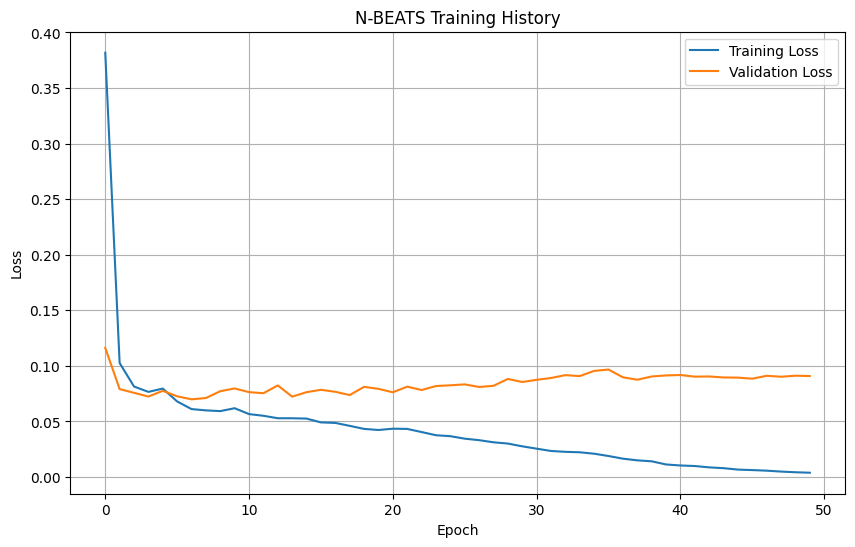

Test Metrics:
MAE: 2.3222
MSE: 9.4072
RMSE: 3.0671
MAPE: 0.0212


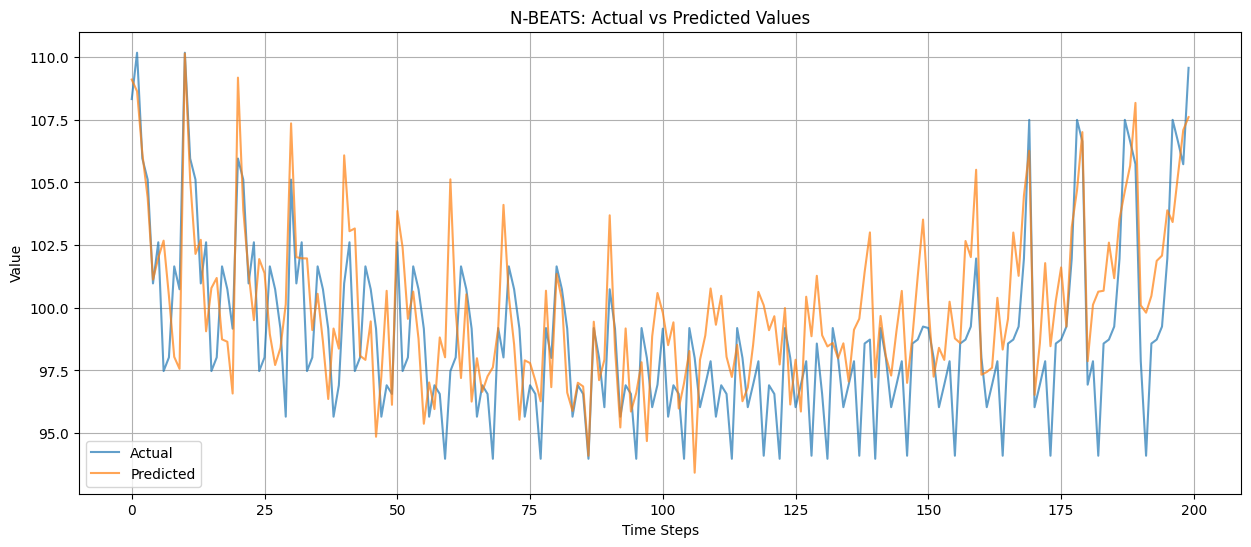

2025/07/31 06:44:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 06:44:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/31 06:44:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/31 06:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

Model registered as: nbeats_best_model
Experiment completed!


In [6]:
# model_experiment_NBEATS.ipynb
# N-BEATS Implementation for Time Series Forecasting

# Install required packages
!pip install torch torchvision torchaudio
!pip install mlflow
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install optuna  # for hyperparameter optimization

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TimeSeriesDataset(Dataset):
    """Custom Dataset for Time Series Data"""
    def __init__(self, data, lookback_window, forecast_horizon):
        self.data = data
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.data) - self.lookback_window - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback_window]
        y = self.data[idx + self.lookback_window:idx + self.lookback_window + self.forecast_horizon]
        return torch.FloatTensor(x), torch.FloatTensor(y)

class NBeatsBlock(nn.Module):
    """Individual N-BEATS block"""
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Fully connected layers
        layers_list = []
        layers_list.append(nn.Linear(input_size, layer_size))
        layers_list.append(nn.ReLU())

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.fc_layers = nn.Sequential(*layers_list)

        # Theta layers for backcast and forecast
        self.theta_b = nn.Linear(layer_size, theta_size)
        self.theta_f = nn.Linear(layer_size, theta_size)

    def forward(self, x):
        # Pass through FC layers
        h = self.fc_layers(x)

        # Generate theta parameters
        theta_b = self.theta_b(h)
        theta_f = self.theta_f(h)

        # Generate basis functions
        backcast = self.basis_function(theta_b, self.input_size, is_forecast=False)
        forecast = self.basis_function(theta_f, self.input_size, is_forecast=True)

        return backcast, forecast

class GenericBasis(nn.Module):
    """Generic basis function for N-BEATS"""
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, is_forecast=False):
        if is_forecast:
            return theta[:, :self.forecast_size]
        else:
            return theta[:, :self.backcast_size]

class TrendBasis(nn.Module):
    """Trend basis function for interpretable N-BEATS"""
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.degree = degree_of_polynomial
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

        # Polynomial basis
        self.polynomial_size = self.degree + 1

    def forward(self, theta, input_size, is_forecast=False):
        batch_size = theta.shape[0]

        if is_forecast:
            time_steps = torch.arange(0, self.forecast_size, dtype=torch.float32).to(theta.device)
        else:
            time_steps = torch.arange(0, self.backcast_size, dtype=torch.float32).to(theta.device)

        # Normalize time steps
        time_steps = time_steps / max(self.backcast_size, self.forecast_size)

        # Create polynomial basis
        basis = torch.stack([time_steps ** i for i in range(self.polynomial_size)], dim=0)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta coefficients
        theta_expanded = theta[:, :self.polynomial_size].unsqueeze(-1)
        output = torch.sum(basis * theta_expanded, dim=1)

        return output

class SeasonalityBasis(nn.Module):
    """Seasonality basis function for interpretable N-BEATS"""
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, is_forecast=False):
        batch_size = theta.shape[0]

        if is_forecast:
            time_steps = torch.arange(0, self.forecast_size, dtype=torch.float32).to(theta.device)
        else:
            time_steps = torch.arange(0, self.backcast_size, dtype=torch.float32).to(theta.device)

        # Normalize time steps
        time_steps = time_steps * 2 * np.pi / max(self.backcast_size, self.forecast_size)

        # Create harmonic basis (sin and cos)
        basis_functions = []
        for i in range(1, self.harmonics + 1):
            basis_functions.append(torch.cos(i * time_steps))
            basis_functions.append(torch.sin(i * time_steps))

        basis = torch.stack(basis_functions, dim=0)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta coefficients
        theta_expanded = theta[:, :2*self.harmonics].unsqueeze(-1)
        output = torch.sum(basis * theta_expanded, dim=1)

        return output

class NBEATSModel(nn.Module):
    """Complete N-BEATS model"""
    def __init__(self, input_size, forecast_size, stack_types=['generic', 'generic'],
                 nb_blocks_per_stack=3, hidden_layer_units=256,
                 share_weights_in_stack=False, nb_harmonics=None,
                 nb_polynomials=None):
        super().__init__()

        self.input_size = input_size
        self.forecast_size = forecast_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.hidden_layer_units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack

        # Default values for interpretable stacks
        self.nb_harmonics = nb_harmonics or input_size // 2
        self.nb_polynomials = nb_polynomials or 3

        # Create stacks
        self.stacks = nn.ModuleList()

        for stack_type in stack_types:
            stack = self.create_stack(stack_type)
            self.stacks.append(stack)

    def create_stack(self, stack_type):
        """Create a stack of N-BEATS blocks"""
        blocks = nn.ModuleList()

        for _ in range(self.nb_blocks_per_stack):
            if stack_type == 'generic':
                theta_size = self.input_size + self.forecast_size
                basis_function = GenericBasis(self.input_size, self.forecast_size)
            elif stack_type == 'trend':
                theta_size = self.nb_polynomials + 1
                basis_function = TrendBasis(self.nb_polynomials, self.input_size, self.forecast_size)
            elif stack_type == 'seasonality':
                theta_size = 2 * self.nb_harmonics
                basis_function = SeasonalityBasis(self.nb_harmonics, self.input_size, self.forecast_size)
            else:
                raise ValueError(f"Unknown stack type: {stack_type}")

            block = NBeatsBlock(
                input_size=self.input_size,
                theta_size=theta_size,
                basis_function=basis_function,
                layers=4,
                layer_size=self.hidden_layer_units
            )
            blocks.append(block)

        return blocks

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

        for stack in self.stacks:
            stack_forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        return forecast

class NBEATSTrainer:
    """N-BEATS model trainer with MLflow integration"""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.scaler = StandardScaler()

    def prepare_data(self, data, lookback_window, forecast_horizon, test_size=0.2):
        """Prepare data for training"""
        with mlflow.start_run(run_name="NBEATS_Data_Preparation"):
            # Log data preparation parameters
            mlflow.log_param("lookback_window", lookback_window)
            mlflow.log_param("forecast_horizon", forecast_horizon)
            mlflow.log_param("test_size", test_size)
            mlflow.log_param("data_length", len(data))

            # Scale the data
            data_scaled = self.scaler.fit_transform(data.reshape(-1, 1)).flatten()

            # Create dataset
            dataset = TimeSeriesDataset(data_scaled, lookback_window, forecast_horizon)

            # Split into train and validation
            train_size = int(len(dataset) * (1 - test_size))
            val_size = len(dataset) - train_size

            train_dataset, val_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size]
            )

            mlflow.log_param("train_size", train_size)
            mlflow.log_param("val_size", val_size)

            return train_dataset, val_dataset

    def train(self, train_dataset, val_dataset, epochs=100, batch_size=32, lr=0.001):
        """Train the N-BEATS model"""

        with mlflow.start_run(run_name="NBEATS_Training"):
            # Log hyperparameters
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("learning_rate", lr)
            mlflow.log_param("optimizer", "Adam")
            mlflow.log_param("loss_function", "MSE")

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize optimizer and loss function
            optimizer = optim.Adam(self.model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            train_losses = []
            val_losses = []
            best_val_loss = float('inf')

            for epoch in range(epochs):
                # Training phase
                self.model.train()
                train_loss = 0.0

                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                    optimizer.zero_grad()
                    outputs = self.model(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                train_loss /= len(train_loader)
                train_losses.append(train_loss)

                # Validation phase
                self.model.eval()
                val_loss = 0.0

                with torch.no_grad():
                    for batch_x, batch_y in val_loader:
                        batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_x)
                        loss = criterion(outputs, batch_y)
                        val_loss += loss.item()

                val_loss /= len(val_loader)
                val_losses.append(val_loss)

                # Log metrics
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("val_loss", val_loss, step=epoch)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = self.model.state_dict().copy()

                if epoch % 10 == 0:
                    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

            # Load best model
            self.model.load_state_dict(best_model_state)

            # Log final metrics
            mlflow.log_metric("best_val_loss", best_val_loss)

            # Create and log training plots
            self.plot_training_history(train_losses, val_losses)

            return train_losses, val_losses

    def plot_training_history(self, train_losses, val_losses):
        """Plot and log training history"""
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('N-BEATS Training History')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_history.png')
        mlflow.log_artifact('training_history.png')
        plt.show()

    def evaluate(self, test_data, lookback_window, forecast_horizon):
        """Evaluate the model and calculate metrics"""

        with mlflow.start_run(run_name="NBEATS_Evaluation"):
            self.model.eval()
            predictions = []
            actuals = []

            # Scale test data
            test_data_scaled = self.scaler.transform(test_data.reshape(-1, 1)).flatten()

            with torch.no_grad():
                for i in range(len(test_data_scaled) - lookback_window - forecast_horizon + 1):
                    x = test_data_scaled[i:i + lookback_window]
                    y = test_data_scaled[i + lookback_window:i + lookback_window + forecast_horizon]

                    x_tensor = torch.FloatTensor(x).unsqueeze(0).to(self.device)
                    pred = self.model(x_tensor).cpu().numpy().flatten()

                    predictions.extend(pred)
                    actuals.extend(y)

            # Inverse transform predictions and actuals
            predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
            actuals = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

            # Calculate metrics
            mae = mean_absolute_error(actuals, predictions)
            mse = mean_squared_error(actuals, predictions)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(actuals, predictions)

            # Log metrics
            mlflow.log_metric("test_mae", mae)
            mlflow.log_metric("test_mse", mse)
            mlflow.log_metric("test_rmse", rmse)
            mlflow.log_metric("test_mape", mape)

            print(f"Test Metrics:")
            print(f"MAE: {mae:.4f}")
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAPE: {mape:.4f}")

            # Plot predictions vs actuals
            self.plot_predictions(actuals, predictions)

            return {
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'mape': mape,
                'predictions': predictions,
                'actuals': actuals
            }

    def plot_predictions(self, actuals, predictions, n_points=200):
        """Plot predictions vs actuals"""
        plt.figure(figsize=(15, 6))

        # Show only last n_points for clarity
        if len(actuals) > n_points:
            actuals_plot = actuals[-n_points:]
            predictions_plot = predictions[-n_points:]
        else:
            actuals_plot = actuals
            predictions_plot = predictions

        plt.plot(actuals_plot, label='Actual', alpha=0.7)
        plt.plot(predictions_plot, label='Predicted', alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('N-BEATS: Actual vs Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.savefig('predictions_plot.png')
        mlflow.log_artifact('predictions_plot.png')
        plt.show()

    def save_model_pipeline(self, experiment_name, model_name):
        """Save the complete model pipeline to MLflow Model Registry"""

        with mlflow.start_run(run_name="NBEATS_Model_Registration"):
            # Create a simple wrapper for the pipeline
            class NBEATSPipeline:
                def __init__(self, model, scaler, lookback_window, forecast_horizon, device):
                    self.model = model
                    self.scaler = scaler
                    self.lookback_window = lookback_window
                    self.forecast_horizon = forecast_horizon
                    self.device = device

                def predict(self, data):
                    """Make predictions on raw data"""
                    # Scale the data
                    data_scaled = self.scaler.transform(data.reshape(-1, 1)).flatten()

                    # Make predictions
                    self.model.eval()
                    predictions = []

                    with torch.no_grad():
                        for i in range(len(data_scaled) - self.lookback_window + 1):
                            x = data_scaled[i:i + self.lookback_window]
                            x_tensor = torch.FloatTensor(x).unsqueeze(0).to(self.device)
                            pred = self.model(x_tensor).cpu().numpy().flatten()
                            predictions.append(pred)

                    # Inverse transform predictions
                    predictions = np.array(predictions)
                    predictions = self.scaler.inverse_transform(
                        predictions.reshape(-1, 1)
                    ).reshape(predictions.shape)

                    return predictions

            # Create pipeline instance
            pipeline = NBEATSPipeline(
                self.model, self.scaler,
                self.model.input_size, self.model.forecast_size,
                self.device
            )

            # Log the model
            mlflow.pytorch.log_model(
                self.model,
                "nbeats_model",
                registered_model_name=model_name
            )

            # Log the scaler
            mlflow.sklearn.log_model(
                self.scaler,
                "scaler"
            )

            print(f"Model registered as: {model_name}")

# Example usage and hyperparameter tuning
def run_nbeats_experiment():
    """Run complete N-BEATS experiment"""

    # Set MLflow experiment
    mlflow.set_experiment("NBEATS_Training")

    # Generate sample time series data (replace with your actual data)
    # This is just for demonstration - use your actual dataset
    np.random.seed(42)
    t = np.arange(0, 1000)
    trend = 0.01 * t
    seasonal = 10 * np.sin(2 * np.pi * t / 50) + 5 * np.sin(2 * np.pi * t / 100)
    noise = np.random.normal(0, 2, len(t))
    data = trend + seasonal + noise + 100

    # Model hyperparameters
    lookback_window = 50
    forecast_horizon = 10

    # Split data
    train_data = data[:800]
    test_data = data[800:]

    # Initialize model
    model = NBEATSModel(
        input_size=lookback_window,
        forecast_size=forecast_horizon,
        stack_types=['trend', 'seasonality', 'generic'],
        nb_blocks_per_stack=3,
        hidden_layer_units=128,
        nb_harmonics=10,
        nb_polynomials=3
    )

    # Initialize trainer
    trainer = NBEATSTrainer(model, device=device)

    # Prepare data
    train_dataset, val_dataset = trainer.prepare_data(
        train_data, lookback_window, forecast_horizon
    )

    # Train model
    train_losses, val_losses = trainer.train(
        train_dataset, val_dataset,
        epochs=50, batch_size=32, lr=0.001
    )

    # Evaluate model
    results = trainer.evaluate(test_data, lookback_window, forecast_horizon)

    # Save model to registry
    trainer.save_model_pipeline("NBEATS_Training", "nbeats_best_model")

    return trainer, results

# Hyperparameter optimization with Optuna (optional)
def optimize_nbeats_hyperparameters(data, n_trials=20):
    """Optimize N-BEATS hyperparameters using Optuna"""

    import optuna

    def objective(trial):
        # Suggest hyperparameters
        hidden_layer_units = trial.suggest_categorical('hidden_layer_units', [64, 128, 256, 512])
        nb_blocks_per_stack = trial.suggest_int('nb_blocks_per_stack', 2, 5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        # Initialize model with suggested parameters
        model = NBEATSModel(
            input_size=50,
            forecast_size=10,
            stack_types=['trend', 'seasonality', 'generic'],
            nb_blocks_per_stack=nb_blocks_per_stack,
            hidden_layer_units=hidden_layer_units
        )

        trainer = NBEATSTrainer(model, device=device)

        # Prepare data
        train_dataset, val_dataset = trainer.prepare_data(data[:800], 50, 10)

        # Train with early stopping
        train_losses, val_losses = trainer.train(
            train_dataset, val_dataset,
            epochs=30, batch_size=batch_size, lr=learning_rate
        )

        return min(val_losses)

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print("Best hyperparameters:")
    print(study.best_params)

    return study.best_params

# Run the experiment
if __name__ == "__main__":
    print("Starting N-BEATS experiment...")
    trainer, results = run_nbeats_experiment()
    print("Experiment completed!")

    # Optional: Run hyperparameter optimization
    # print("Starting hyperparameter optimization...")
    # best_params = optimize_nbeats_hyperparameters(data)
    # print("Optimization completed!")

Using device: cuda
=== Enhanced N-BEATS with WMAE Implementation ===
Generating synthetic time series data...
Data shape: (1200,)
Data range: [84.65, 128.57]


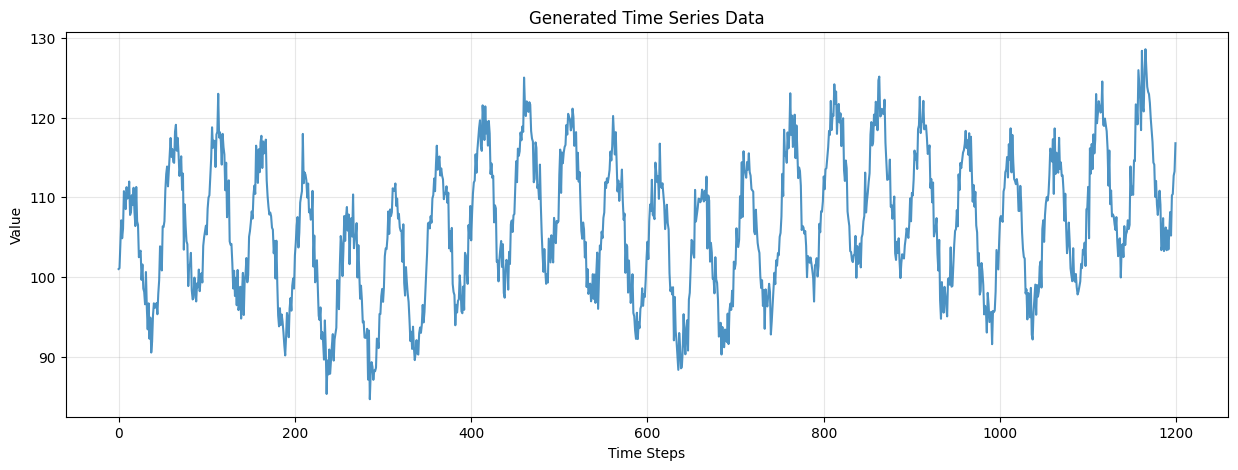

2025/07/31 06:51:52 INFO mlflow.tracking.fluent: Experiment with name 'NBEATS_WMAE_Training' does not exist. Creating a new experiment.



1. Running main N-BEATS experiment with WMAE...
Starting model training...
Epoch [0/100], Train Loss: 1.477578, Val Loss: 0.587695, LR: 1.00e-03
Epoch [10/100], Train Loss: 0.378703, Val Loss: 0.367107, LR: 1.00e-03
Epoch [20/100], Train Loss: 0.336070, Val Loss: 0.349065, LR: 1.00e-03
Epoch [30/100], Train Loss: 0.297467, Val Loss: 0.349591, LR: 5.00e-04
Epoch [40/100], Train Loss: 0.273810, Val Loss: 0.359722, LR: 2.50e-04
Early stopping at epoch 42


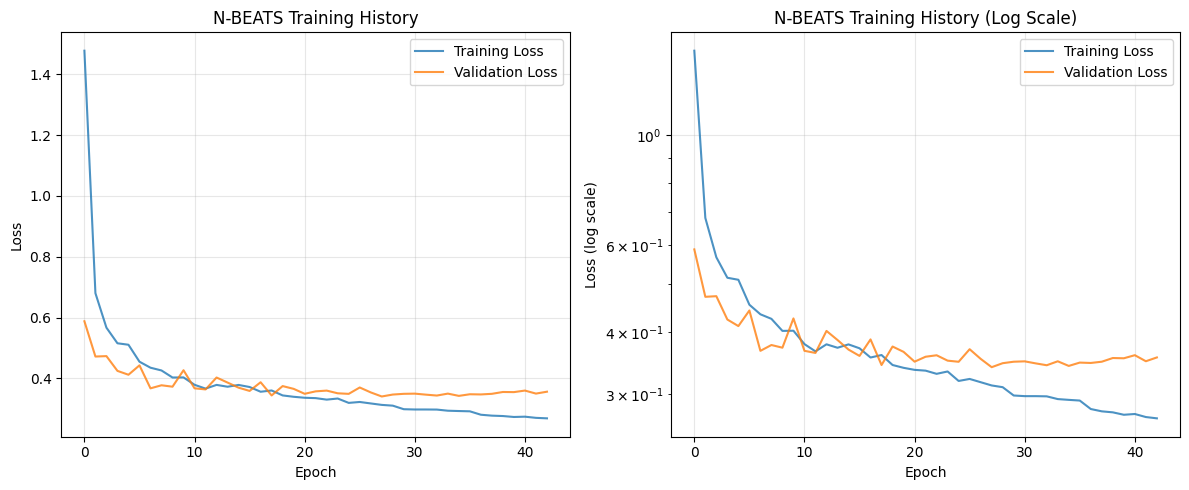

Evaluating model...
=== N-BEATS Model Evaluation Results ===
Primary Metric (WMAE - Linear):  1.5528
WMAE (Equal weights):           1.9865
WMAE (Exponential weights):     1.5486
WMAE (Horizon weights):         1.5512
Standard MAE:                   1.9865
RMSE:                           2.5273
MAPE:                           1.81%


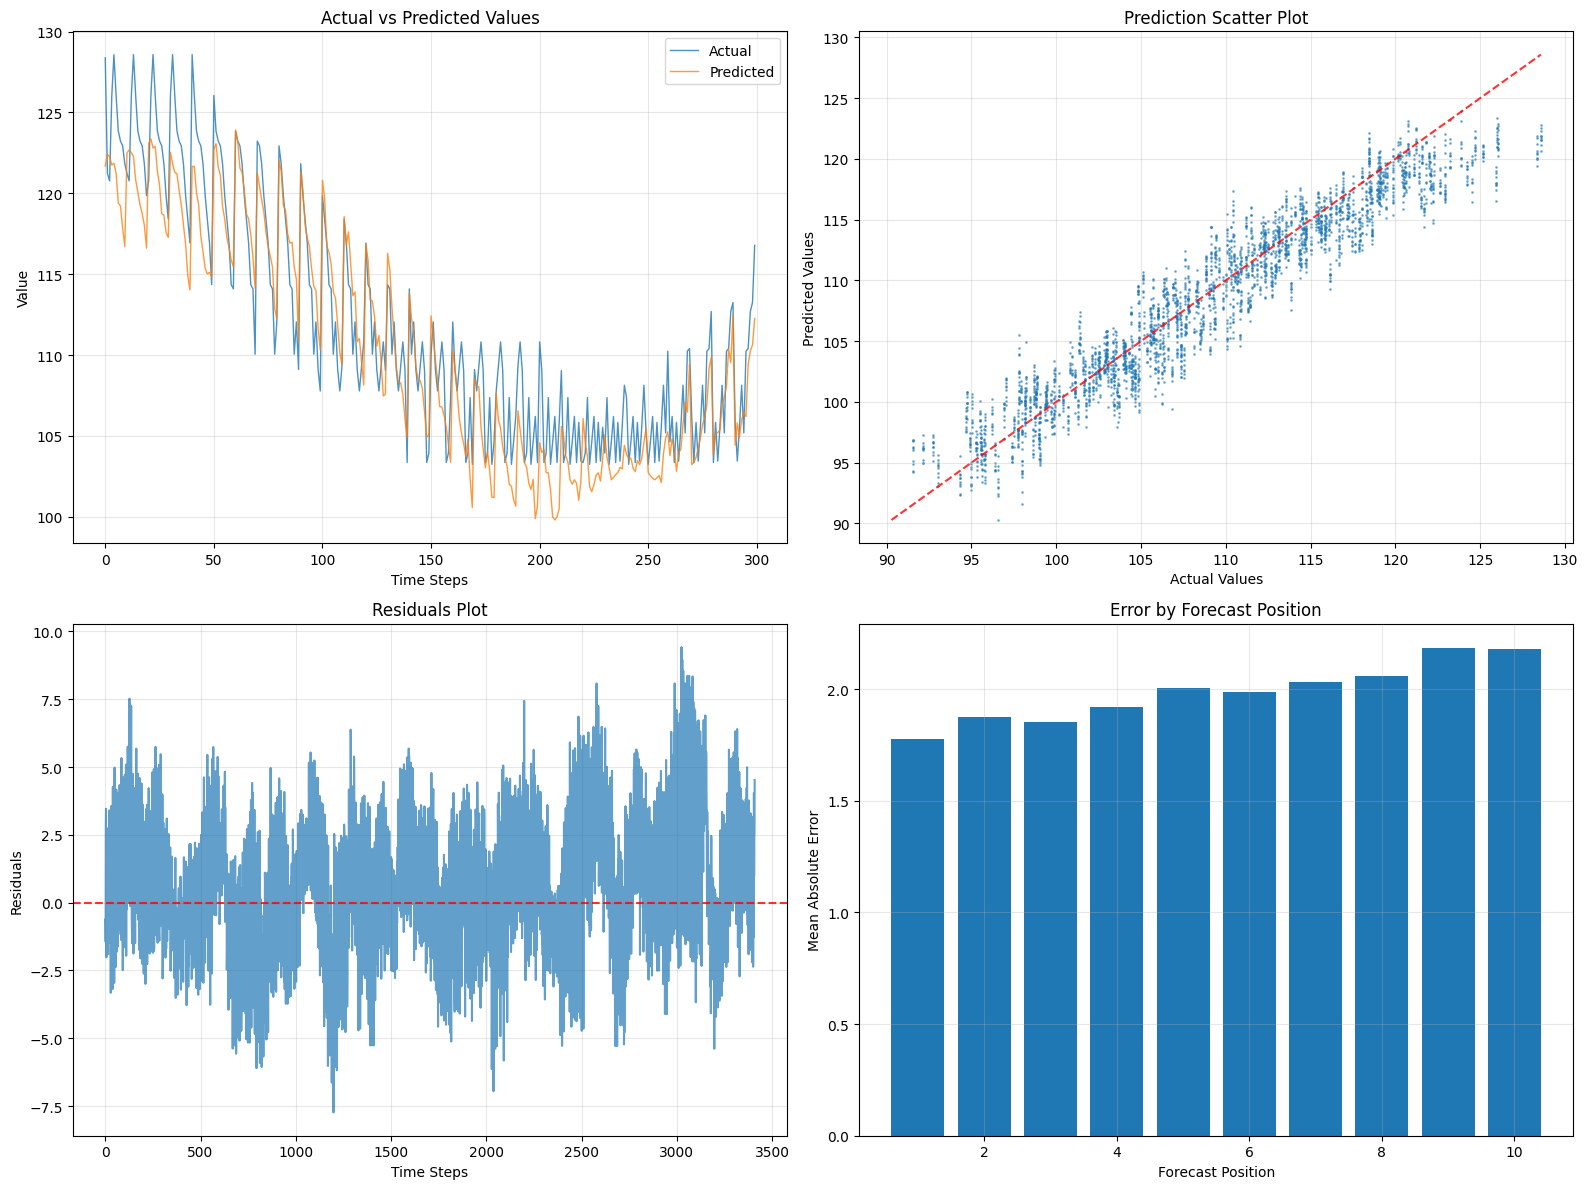

2025/07/31 06:52:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 06:52:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/31 06:52:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/31 06:52:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

Model registered as: nbeats_wmae_model

Main experiment completed!
Primary WMAE: 1.5528

2. Running model architecture comparison...

=== Training Generic_Only ===
Epoch [0/50], Train Loss: 0.838124, Val Loss: 0.508025, LR: 1.00e-03
Epoch [10/50], Train Loss: 0.351623, Val Loss: 0.350239, LR: 1.00e-03
Epoch [20/50], Train Loss: 0.316905, Val Loss: 0.356132, LR: 5.00e-04
Early stopping at epoch 24


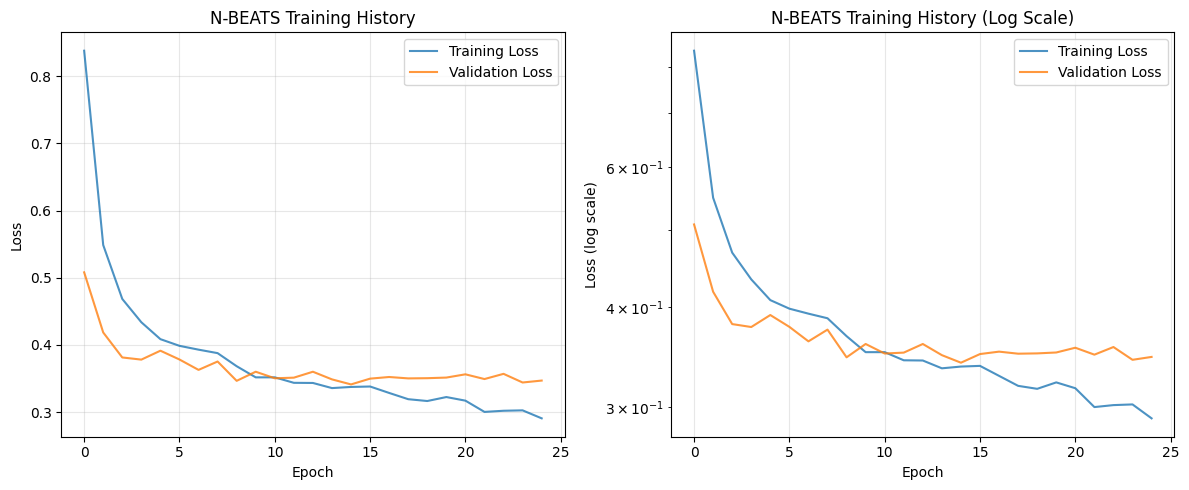

=== N-BEATS Model Evaluation Results ===
Primary Metric (WMAE - Linear):  1.4830
WMAE (Equal weights):           2.0220
WMAE (Exponential weights):     1.4556
WMAE (Horizon weights):         1.4864
Standard MAE:                   2.0220
RMSE:                           2.5518
MAPE:                           1.86%


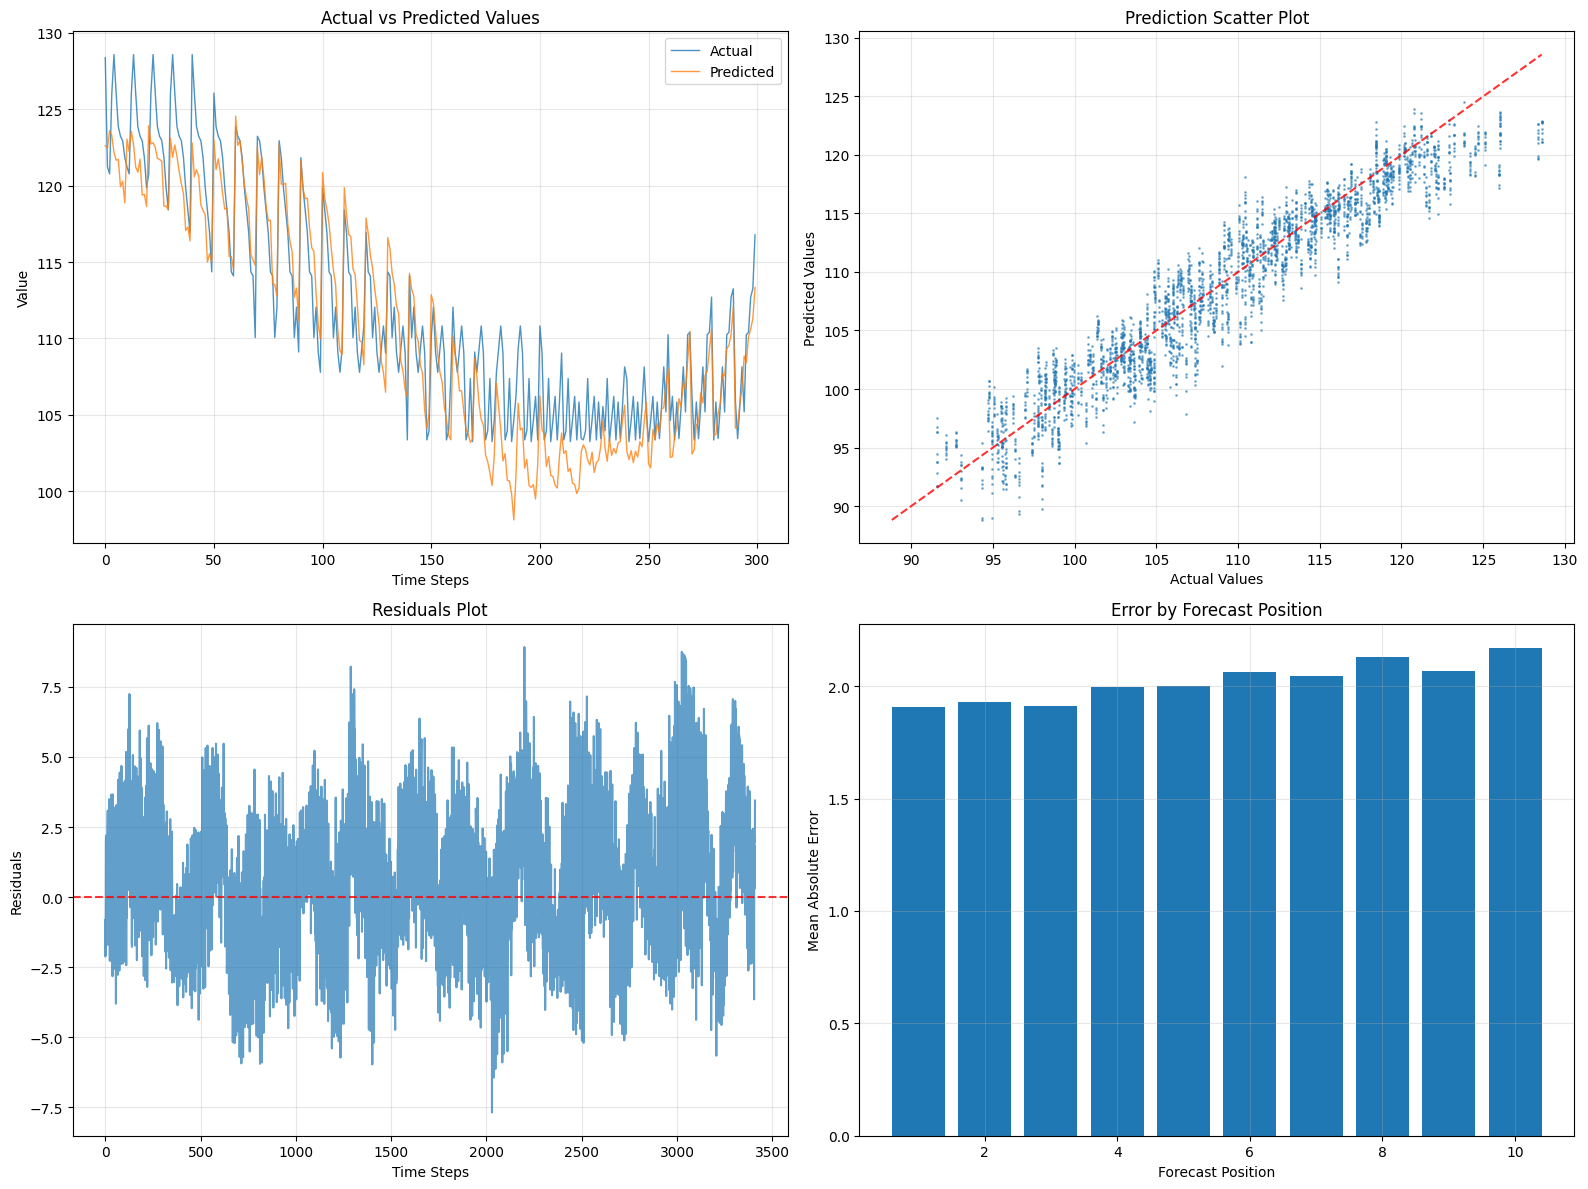


=== Training Interpretable_Only ===
Epoch [0/50], Train Loss: 1.333268, Val Loss: 0.658658, LR: 1.00e-03
Epoch [10/50], Train Loss: 0.390998, Val Loss: 0.388929, LR: 1.00e-03
Epoch [20/50], Train Loss: 0.336947, Val Loss: 0.361045, LR: 1.00e-03
Epoch [30/50], Train Loss: 0.308672, Val Loss: 0.346942, LR: 5.00e-04
Epoch [40/50], Train Loss: 0.288557, Val Loss: 0.349504, LR: 2.50e-04
Early stopping at epoch 41


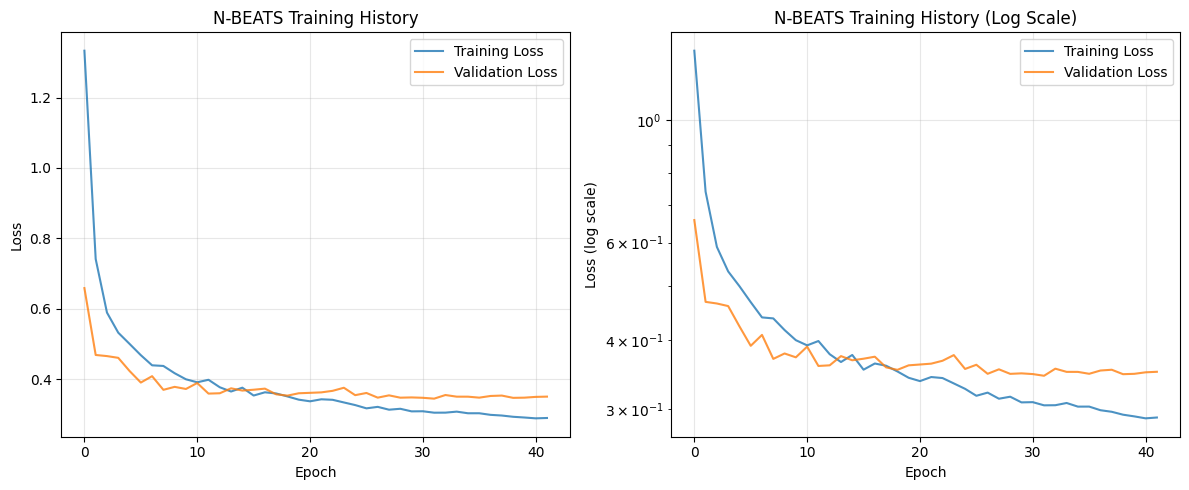

=== N-BEATS Model Evaluation Results ===
Primary Metric (WMAE - Linear):  1.4302
WMAE (Equal weights):           1.9622
WMAE (Exponential weights):     1.4404
WMAE (Horizon weights):         1.4274
Standard MAE:                   1.9622
RMSE:                           2.4792
MAPE:                           1.79%


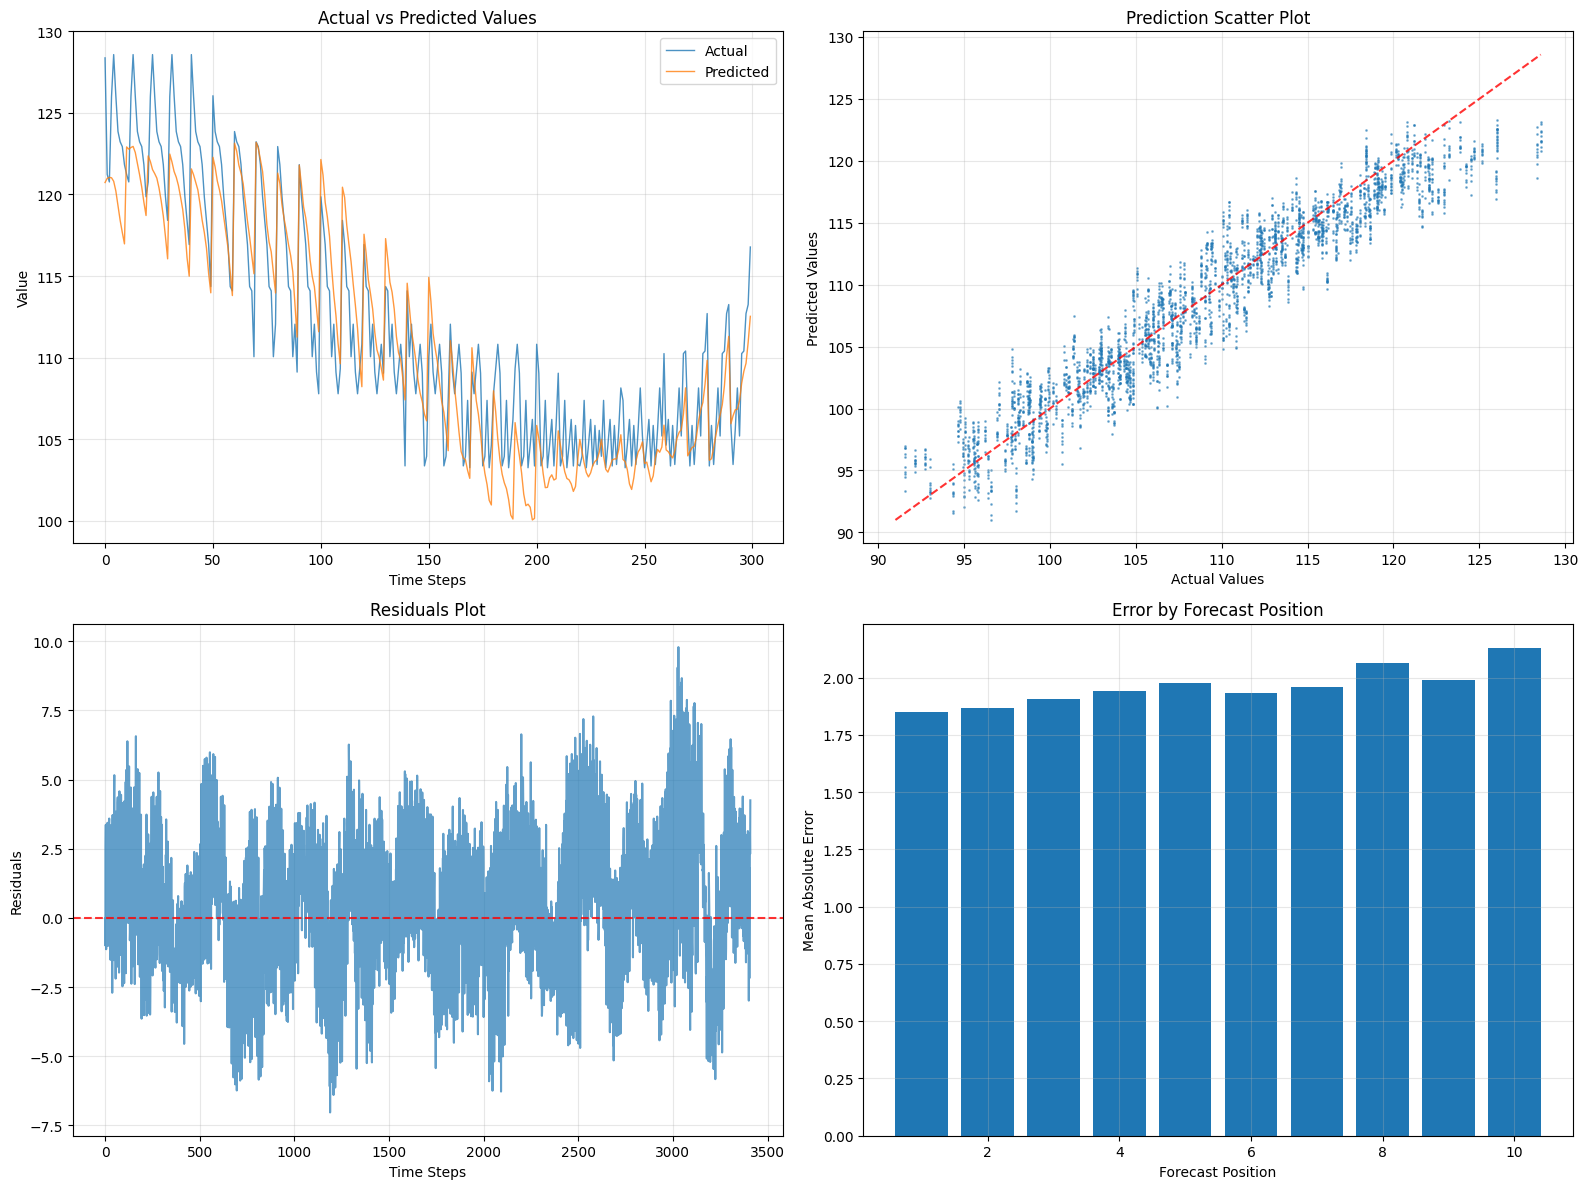


=== Training Mixed_Architecture ===
Epoch [0/50], Train Loss: 1.425718, Val Loss: 0.529251, LR: 1.00e-03
Epoch [10/50], Train Loss: 0.388567, Val Loss: 0.364641, LR: 1.00e-03
Epoch [20/50], Train Loss: 0.323773, Val Loss: 0.334503, LR: 5.00e-04
Early stopping at epoch 30


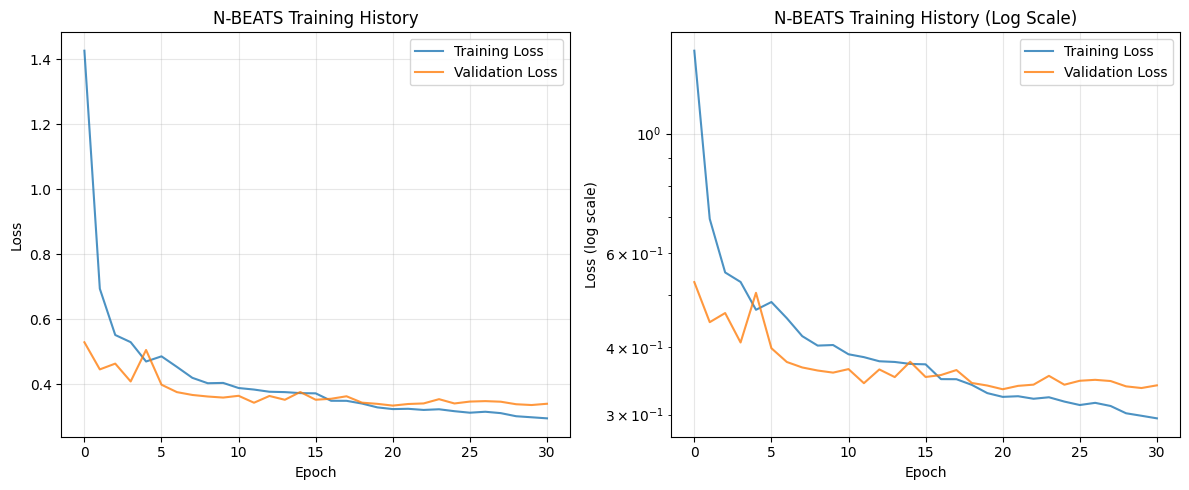

=== N-BEATS Model Evaluation Results ===
Primary Metric (WMAE - Linear):  1.3465
WMAE (Equal weights):           1.9903
WMAE (Exponential weights):     1.3441
WMAE (Horizon weights):         1.3444
Standard MAE:                   1.9903
RMSE:                           2.5315
MAPE:                           1.82%


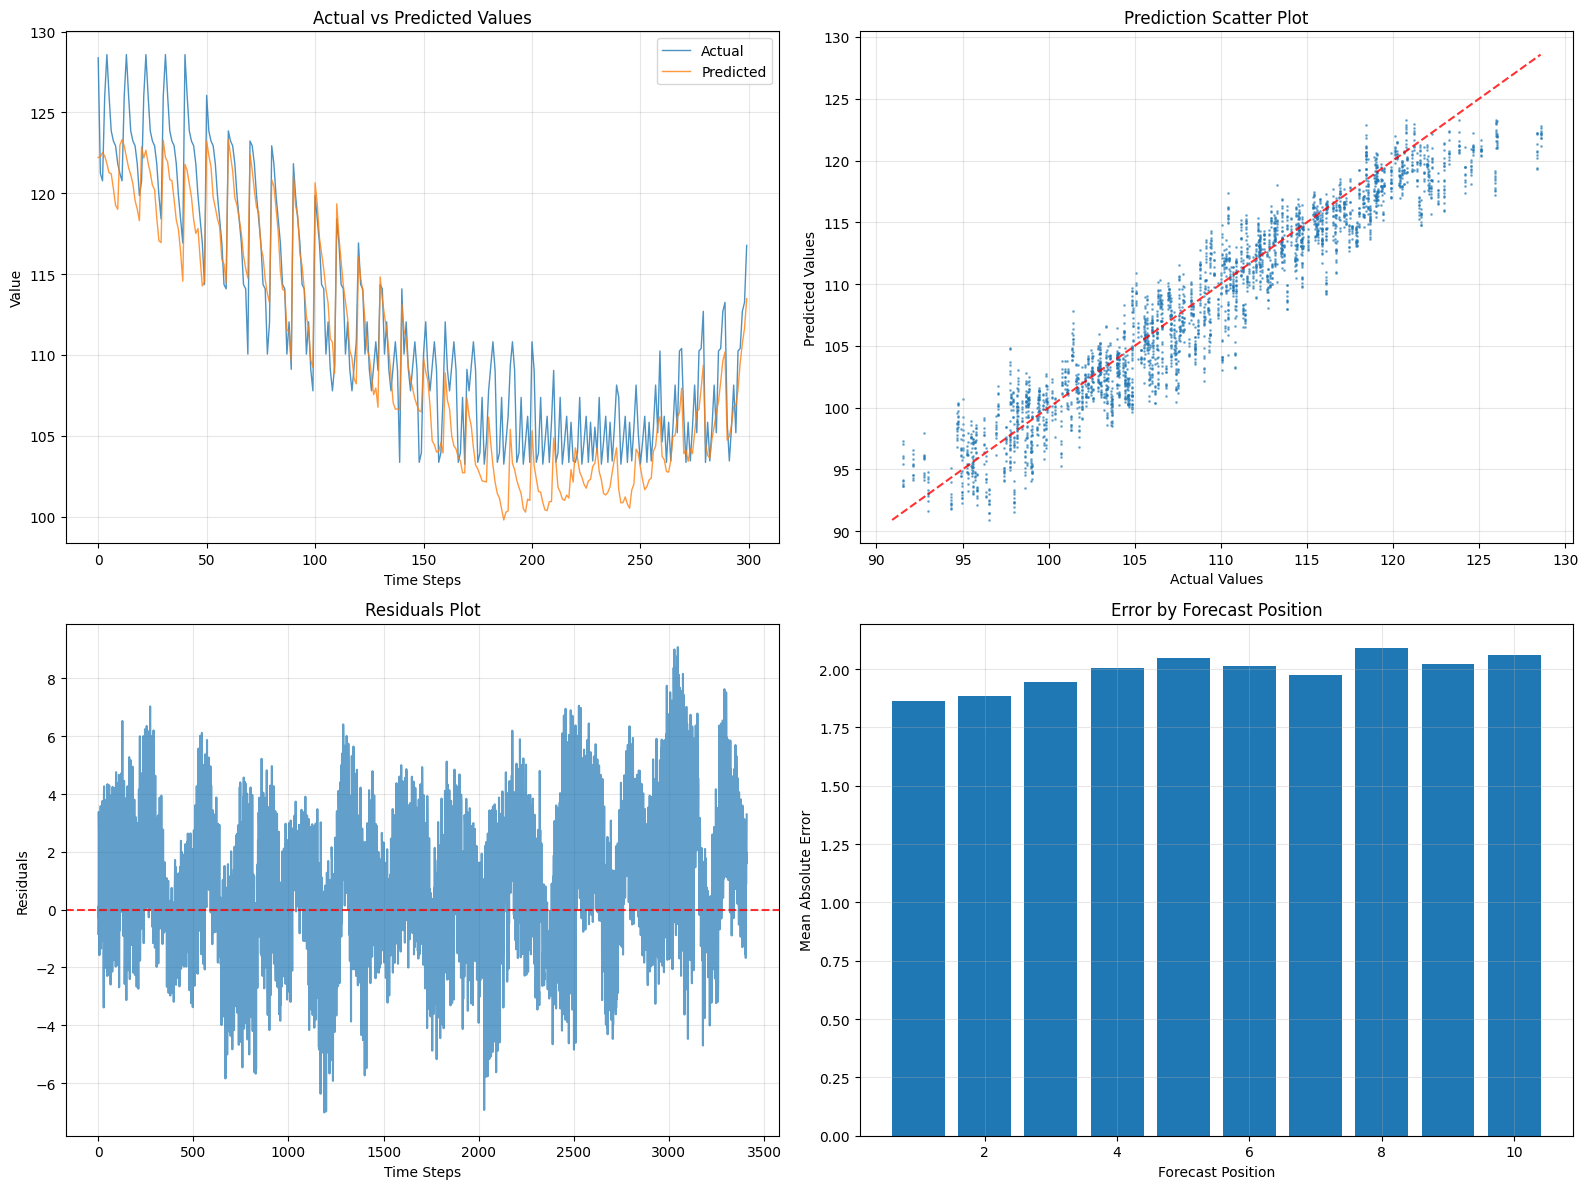


=== Training Deep_Generic ===
Epoch [0/50], Train Loss: 0.753148, Val Loss: 0.514147, LR: 1.00e-03
Epoch [10/50], Train Loss: 0.344115, Val Loss: 0.378896, LR: 1.00e-03
Epoch [20/50], Train Loss: 0.282176, Val Loss: 0.355192, LR: 5.00e-04
Epoch [30/50], Train Loss: 0.229728, Val Loss: 0.356479, LR: 2.50e-04
Early stopping at epoch 31


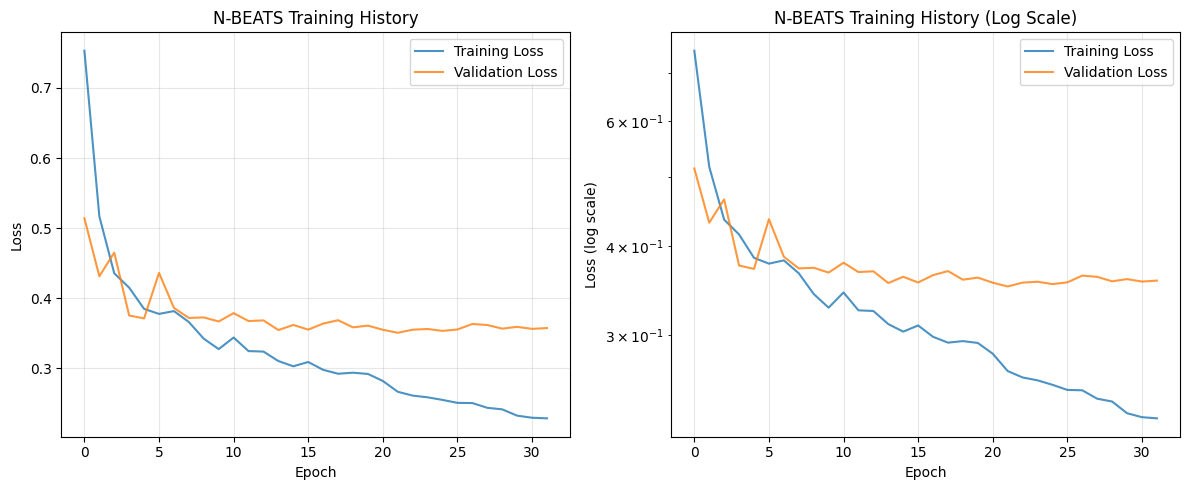

=== N-BEATS Model Evaluation Results ===
Primary Metric (WMAE - Linear):  1.3147
WMAE (Equal weights):           2.0234
WMAE (Exponential weights):     1.2917
WMAE (Horizon weights):         1.3168
Standard MAE:                   2.0234
RMSE:                           2.5509
MAPE:                           1.86%


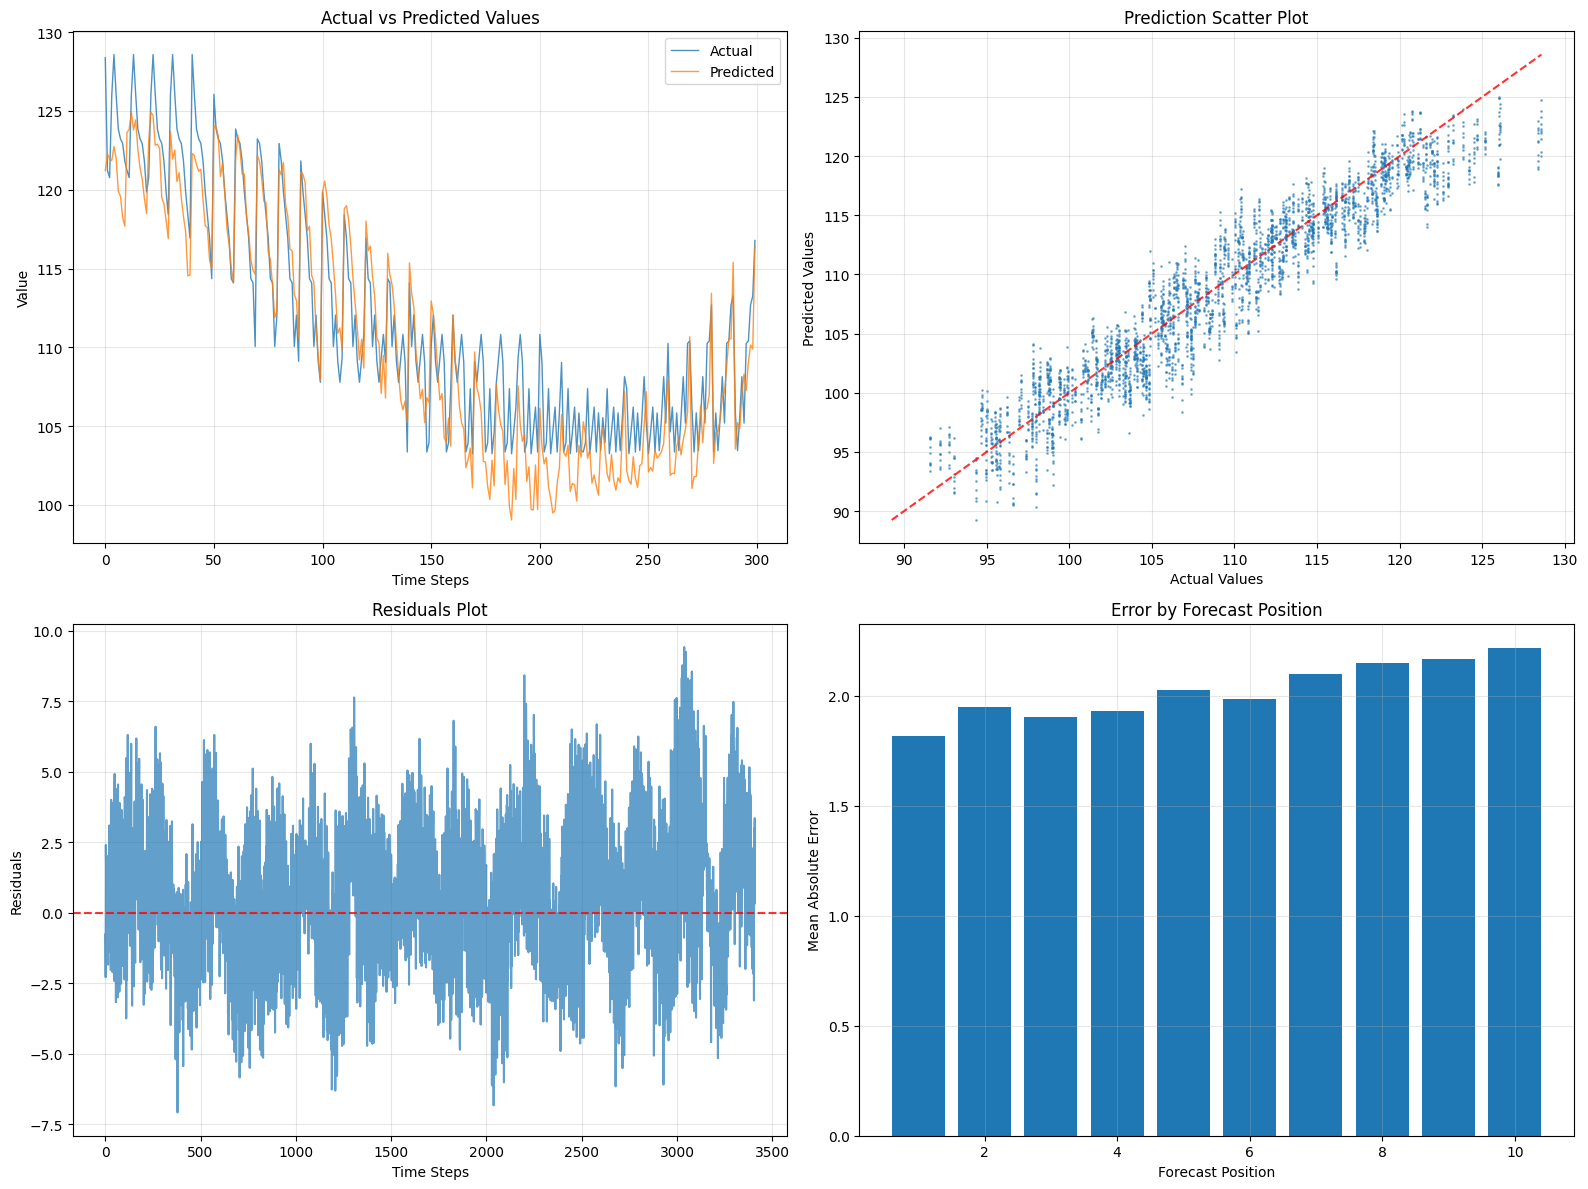


=== Model Comparison Results (WMAE) ===
1. Deep_Generic
   WMAE: 1.3147
   MAE:  2.0234
   RMSE: 2.5509
   MAPE: 1.86%

2. Mixed_Architecture
   WMAE: 1.3465
   MAE:  1.9903
   RMSE: 2.5315
   MAPE: 1.82%

3. Interpretable_Only
   WMAE: 1.4302
   MAE:  1.9622
   RMSE: 2.4792
   MAPE: 1.79%

4. Generic_Only
   WMAE: 1.4830
   MAE:  2.0220
   RMSE: 2.5518
   MAPE: 1.86%


3. Generating future forecasts...


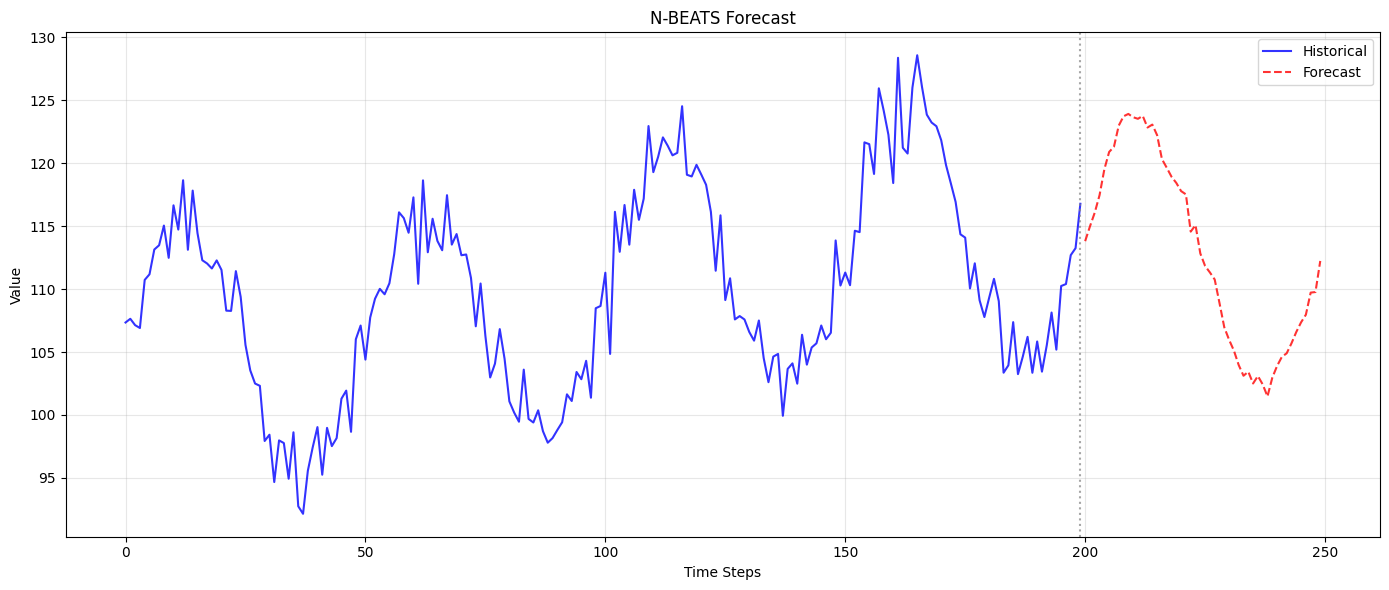

KeyboardInterrupt: Interrupted by user

In [7]:
# model_experiment_NBEATS.ipynb
# Enhanced N-BEATS Implementation for Time Series Forecasting with WMAE

# Install required packages
!pip install torch torchvision torchaudio
!pip install mlflow
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install optuna  # for hyperparameter optimization

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class WeightedMAE(nn.Module):
    """Weighted Mean Absolute Error Loss"""
    def __init__(self, weights=None):
        super(WeightedMAE, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        if self.weights is not None:
            if isinstance(self.weights, (list, np.ndarray)):
                weights = torch.tensor(self.weights, dtype=torch.float32).to(predictions.device)
            else:
                weights = self.weights.to(predictions.device)

            # Ensure weights match the prediction dimensions
            if weights.dim() == 1 and predictions.dim() == 2:
                weights = weights.unsqueeze(0).expand_as(predictions)

            mae = torch.abs(predictions - targets)
            wmae = torch.mean(weights * mae)
        else:
            wmae = torch.mean(torch.abs(predictions - targets))

        return wmae

def calculate_wmae(y_true, y_pred, weights=None):
    """Calculate Weighted Mean Absolute Error"""
    if weights is None:
        return mean_absolute_error(y_true, y_pred)

    if isinstance(weights, (list, np.ndarray)):
        weights = np.array(weights)

    # Ensure weights are the same shape as predictions
    if len(weights.shape) == 1 and len(y_pred.shape) == 1:
        if len(weights) != len(y_pred):
            # If weights length doesn't match, repeat or truncate
            if len(weights) < len(y_pred):
                weights = np.tile(weights, (len(y_pred) // len(weights)) + 1)[:len(y_pred)]
            else:
                weights = weights[:len(y_pred)]

    mae = np.abs(y_true - y_pred)
    wmae = np.average(mae, weights=weights)
    return wmae

class TimeSeriesDataset(Dataset):
    """Enhanced Custom Dataset for Time Series Data"""
    def __init__(self, data, lookback_window, forecast_horizon, weights=None):
        self.data = data
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.weights = weights

    def __len__(self):
        return len(self.data) - self.lookback_window - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback_window]
        y = self.data[idx + self.lookback_window:idx + self.lookback_window + self.forecast_horizon]

        sample = {
            'input': torch.FloatTensor(x),
            'target': torch.FloatTensor(y)
        }

        if self.weights is not None:
            if isinstance(self.weights, (list, np.ndarray)):
                weights = self.weights
            else:
                # Generate time-based weights (more recent predictions get higher weights)
                weights = np.linspace(1.0, 2.0, self.forecast_horizon)
            sample['weights'] = torch.FloatTensor(weights[:self.forecast_horizon])

        return sample

class NBeatsBlock(nn.Module):
    """Enhanced N-BEATS block with better initialization"""
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Fully connected layers with dropout
        layers_list = []
        layers_list.append(nn.Linear(input_size, layer_size))
        layers_list.append(nn.ReLU())
        layers_list.append(nn.Dropout(dropout))

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())
            layers_list.append(nn.Dropout(dropout))

        self.fc_layers = nn.Sequential(*layers_list)

        # Theta layers for backcast and forecast
        self.theta_b = nn.Linear(layer_size, theta_size)
        self.theta_f = nn.Linear(layer_size, theta_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # Pass through FC layers
        h = self.fc_layers(x)

        # Generate theta parameters
        theta_b = self.theta_b(h)
        theta_f = self.theta_f(h)

        # Generate basis functions
        backcast = self.basis_function(theta_b, self.input_size, is_forecast=False)
        forecast = self.basis_function(theta_f, self.input_size, is_forecast=True)

        return backcast, forecast

class GenericBasis(nn.Module):
    """Enhanced Generic basis function for N-BEATS"""
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, is_forecast=False):
        if is_forecast:
            return theta[:, :self.forecast_size]
        else:
            return theta[:, :self.backcast_size]

class TrendBasis(nn.Module):
    """Enhanced Trend basis function for interpretable N-BEATS"""
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.degree = degree_of_polynomial
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        self.polynomial_size = self.degree + 1

    def forward(self, theta, input_size, is_forecast=False):
        batch_size = theta.shape[0]

        if is_forecast:
            time_steps = torch.arange(0, self.forecast_size, dtype=torch.float32).to(theta.device)
        else:
            time_steps = torch.arange(0, self.backcast_size, dtype=torch.float32).to(theta.device)

        # Normalize time steps
        time_steps = time_steps / max(self.backcast_size, self.forecast_size)

        # Create polynomial basis
        basis = torch.stack([time_steps ** i for i in range(self.polynomial_size)], dim=0)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta coefficients
        theta_expanded = theta[:, :self.polynomial_size].unsqueeze(-1)
        output = torch.sum(basis * theta_expanded, dim=1)

        return output

class SeasonalityBasis(nn.Module):
    """Enhanced Seasonality basis function for interpretable N-BEATS"""
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, is_forecast=False):
        batch_size = theta.shape[0]

        if is_forecast:
            time_steps = torch.arange(0, self.forecast_size, dtype=torch.float32).to(theta.device)
        else:
            time_steps = torch.arange(0, self.backcast_size, dtype=torch.float32).to(theta.device)

        # Normalize time steps
        time_steps = time_steps * 2 * np.pi / max(self.backcast_size, self.forecast_size)

        # Create harmonic basis (sin and cos)
        basis_functions = []
        for i in range(1, self.harmonics + 1):
            basis_functions.append(torch.cos(i * time_steps))
            basis_functions.append(torch.sin(i * time_steps))

        basis = torch.stack(basis_functions, dim=0)
        basis = basis.unsqueeze(0).repeat(batch_size, 1, 1)

        # Apply theta coefficients
        theta_expanded = theta[:, :2*self.harmonics].unsqueeze(-1)
        output = torch.sum(basis * theta_expanded, dim=1)

        return output

class NBEATSModel(nn.Module):
    """Enhanced N-BEATS model with better architecture"""
    def __init__(self, input_size, forecast_size, stack_types=['generic', 'generic'],
                 nb_blocks_per_stack=3, hidden_layer_units=256,
                 share_weights_in_stack=False, nb_harmonics=None,
                 nb_polynomials=None, dropout=0.1):
        super().__init__()
        self.input_size = input_size
        self.forecast_size = forecast_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.hidden_layer_units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.dropout = dropout

        # Default values for interpretable stacks
        self.nb_harmonics = nb_harmonics or max(1, input_size // 4)
        self.nb_polynomials = nb_polynomials or 3

        # Create stacks
        self.stacks = nn.ModuleList()
        for stack_type in stack_types:
            stack = self.create_stack(stack_type)
            self.stacks.append(stack)

    def create_stack(self, stack_type):
        """Create a stack of N-BEATS blocks"""
        blocks = nn.ModuleList()

        for _ in range(self.nb_blocks_per_stack):
            if stack_type == 'generic':
                theta_size = self.input_size + self.forecast_size
                basis_function = GenericBasis(self.input_size, self.forecast_size)
            elif stack_type == 'trend':
                theta_size = self.nb_polynomials + 1
                basis_function = TrendBasis(self.nb_polynomials, self.input_size, self.forecast_size)
            elif stack_type == 'seasonality':
                theta_size = 2 * self.nb_harmonics
                basis_function = SeasonalityBasis(self.nb_harmonics, self.input_size, self.forecast_size)
            else:
                raise ValueError(f"Unknown stack type: {stack_type}")

            block = NBeatsBlock(
                input_size=self.input_size,
                theta_size=theta_size,
                basis_function=basis_function,
                layers=4,
                layer_size=self.hidden_layer_units,
                dropout=self.dropout
            )
            blocks.append(block)

        return blocks

    def forward(self, x):
        residual = x
        forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

        for stack in self.stacks:
            stack_forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        return forecast

class NBEATSTrainer:
    """Enhanced N-BEATS model trainer with WMAE focus and MLflow integration"""
    def __init__(self, model, device='cpu', use_wmae=True, forecast_weights=None):
        self.model = model.to(device)
        self.device = device
        self.scaler = StandardScaler()
        self.use_wmae = use_wmae
        self.forecast_weights = forecast_weights

        # Initialize loss function
        if use_wmae:
            self.criterion = WeightedMAE(weights=forecast_weights)
        else:
            self.criterion = nn.MSELoss()

    def prepare_data(self, data, lookback_window, forecast_horizon, test_size=0.2, weights=None):
        """Prepare data for training with optional weights"""
        with mlflow.start_run(run_name="NBEATS_Data_Preparation", nested=True):
            # Log data preparation parameters
            mlflow.log_param("lookback_window", lookback_window)
            mlflow.log_param("forecast_horizon", forecast_horizon)
            mlflow.log_param("test_size", test_size)
            mlflow.log_param("data_length", len(data))
            mlflow.log_param("use_wmae", self.use_wmae)

            # Scale the data
            data_scaled = self.scaler.fit_transform(data.reshape(-1, 1)).flatten()

            # Create dataset with weights
            dataset = TimeSeriesDataset(data_scaled, lookback_window, forecast_horizon, weights)

            # Split into train and validation
            train_size = int(len(dataset) * (1 - test_size))
            val_size = len(dataset) - train_size

            train_dataset, val_dataset = torch.utils.data.random_split(
                dataset, [train_size, val_size]
            )

            mlflow.log_param("train_size", train_size)
            mlflow.log_param("val_size", val_size)

            return train_dataset, val_dataset

    def train(self, train_dataset, val_dataset, epochs=100, batch_size=32, lr=0.001,
              patience=15, min_delta=1e-6):
        """Train the N-BEATS model with early stopping"""
        with mlflow.start_run(run_name="NBEATS_Training", nested=True):
            # Log hyperparameters
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("learning_rate", lr)
            mlflow.log_param("optimizer", "Adam")
            mlflow.log_param("loss_function", "WMAE" if self.use_wmae else "MSE")
            mlflow.log_param("patience", patience)
            mlflow.log_param("min_delta", min_delta)

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize optimizer and scheduler
            optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience//2, verbose=True
            )

            train_losses = []
            val_losses = []
            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(epochs):
                # Training phase
                self.model.train()
                train_loss = 0.0

                for batch_data in train_loader:
                    if isinstance(batch_data, dict):
                        batch_x = batch_data['input'].to(self.device)
                        batch_y = batch_data['target'].to(self.device)
                        batch_weights = batch_data.get('weights')
                    else:
                        batch_x, batch_y = batch_data
                        batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                        batch_weights = None

                    optimizer.zero_grad()
                    outputs = self.model(batch_x)

                    if self.use_wmae and batch_weights is not None:
                        loss = self.criterion(outputs, batch_y)
                    else:
                        loss = self.criterion(outputs, batch_y)

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()

                train_loss /= len(train_loader)
                train_losses.append(train_loss)

                # Validation phase
                self.model.eval()
                val_loss = 0.0

                with torch.no_grad():
                    for batch_data in val_loader:
                        if isinstance(batch_data, dict):
                            batch_x = batch_data['input'].to(self.device)
                            batch_y = batch_data['target'].to(self.device)
                        else:
                            batch_x, batch_y = batch_data
                            batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                        outputs = self.model(batch_x)
                        loss = self.criterion(outputs, batch_y)
                        val_loss += loss.item()

                val_loss /= len(val_loader)
                val_losses.append(val_loss)

                # Learning rate scheduling
                scheduler.step(val_loss)

                # Log metrics
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("val_loss", val_loss, step=epoch)
                mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

                # Early stopping and model saving
                if val_loss < best_val_loss - min_delta:
                    best_val_loss = val_loss
                    best_model_state = self.model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.6f}, '
                          f'Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')

            # Load best model
            self.model.load_state_dict(best_model_state)

            # Log final metrics
            mlflow.log_metric("best_val_loss", best_val_loss)
            mlflow.log_metric("final_epoch", epoch)

            # Create and log training plots
            self.plot_training_history(train_losses, val_losses)

            return train_losses, val_losses

    def plot_training_history(self, train_losses, val_losses):
        """Plot and log training history"""
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', alpha=0.8)
        plt.plot(val_losses, label='Validation Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('N-BEATS Training History')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Loss plot (log scale)
        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Training Loss', alpha=0.8)
        plt.plot(val_losses, label='Validation Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.title('N-BEATS Training History (Log Scale)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('training_history.png')
        plt.show()

    def evaluate(self, test_data, lookback_window, forecast_horizon):
        """Evaluate the model with focus on WMAE and other metrics"""
        with mlflow.start_run(run_name="NBEATS_Evaluation", nested=True):
            self.model.eval()
            predictions = []
            actuals = []

            # Scale test data
            test_data_scaled = self.scaler.transform(test_data.reshape(-1, 1)).flatten()

            with torch.no_grad():
                for i in range(len(test_data_scaled) - lookback_window - forecast_horizon + 1):
                    x = test_data_scaled[i:i + lookback_window]
                    y = test_data_scaled[i + lookback_window:i + lookback_window + forecast_horizon]

                    x_tensor = torch.FloatTensor(x).unsqueeze(0).to(self.device)
                    pred = self.model(x_tensor).cpu().numpy().flatten()

                    predictions.extend(pred)
                    actuals.extend(y)

            # Inverse transform predictions and actuals
            predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
            actuals = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

            # Calculate metrics with focus on WMAE
            mae = mean_absolute_error(actuals, predictions)
            mse = mean_squared_error(actuals, predictions)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(actuals, predictions) * 100

            # Calculate WMAE with different weighting schemes
            # 1. Equal weights (standard MAE)
            wmae_equal = calculate_wmae(actuals, predictions)

            # 2. Linear increasing weights (recent predictions more important)
            linear_weights = np.linspace(1.0, 2.0, forecast_horizon)
            wmae_linear = calculate_wmae(actuals[:len(linear_weights)],
                                       predictions[:len(linear_weights)],
                                       linear_weights)

            # 3. Exponential weights
            exp_weights = np.exp(np.linspace(0, 1, forecast_horizon))
            wmae_exp = calculate_wmae(actuals[:len(exp_weights)],
                                    predictions[:len(exp_weights)],
                                    exp_weights)

            # 4. Custom weights based on forecast horizon positions
            horizon_weights = np.array([1.0 + 0.1*i for i in range(forecast_horizon)])
            wmae_horizon = calculate_wmae(actuals[:len(horizon_weights)],
                                        predictions[:len(horizon_weights)],
                                        horizon_weights)

            # Log all metrics
            metrics = {
                'test_mae': mae,
                'test_mse': mse,
                'test_rmse': rmse,
                'test_mape': mape,
                'test_wmae_equal': wmae_equal,
                'test_wmae_linear': wmae_linear,
                'test_wmae_exponential': wmae_exp,
                'test_wmae_horizon': wmae_horizon
            }

            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(metric_name, metric_value)

            # Print results with WMAE emphasis
            print(f"=== N-BEATS Model Evaluation Results ===")
            print(f"Primary Metric (WMAE - Linear):  {wmae_linear:.4f}")
            print(f"WMAE (Equal weights):           {wmae_equal:.4f}")
            print(f"WMAE (Exponential weights):     {wmae_exp:.4f}")
            print(f"WMAE (Horizon weights):         {wmae_horizon:.4f}")
            print(f"Standard MAE:                   {mae:.4f}")
            print(f"RMSE:                           {rmse:.4f}")
            print(f"MAPE:                           {mape:.2f}%")

            # Create comprehensive evaluation plots
            self.plot_comprehensive_evaluation(actuals, predictions, forecast_horizon)

            return {
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'mape': mape,
                'wmae_equal': wmae_equal,
                'wmae_linear': wmae_linear,
                'wmae_exponential': wmae_exp,
                'wmae_horizon': wmae_horizon,
                'predictions': predictions,
                'actuals': actuals,
                'primary_metric': wmae_linear  # Main metric for optimization
            }

    def plot_comprehensive_evaluation(self, actuals, predictions, forecast_horizon, n_points=300):
        """Create comprehensive evaluation plots"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Time series plot
        if len(actuals) > n_points:
            actuals_plot = actuals[-n_points:]
            predictions_plot = predictions[-n_points:]
        else:
            actuals_plot = actuals
            predictions_plot = predictions

        axes[0, 0].plot(actuals_plot, label='Actual', alpha=0.8, linewidth=1)
        axes[0, 0].plot(predictions_plot, label='Predicted', alpha=0.8, linewidth=1)
        axes[0, 0].set_xlabel('Time Steps')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].set_title('Actual vs Predicted Values')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Scatter plot
        axes[0, 1].scatter(actuals, predictions, alpha=0.5, s=1)
        min_val = min(min(actuals), min(predictions))
        max_val = max(max(actuals), max(predictions))
        axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('Actual Values')
        axes[0, 1].set_ylabel('Predicted Values')
        axes[0, 1].set_title('Prediction Scatter Plot')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Residuals plot
        residuals = np.array(actuals) - np.array(predictions)
        axes[1, 0].plot(residuals, alpha=0.7)
        axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
        axes[1, 0].set_xlabel('Time Steps')
        axes[1, 0].set_ylabel('Residuals')
        axes[1, 0].set_title('Residuals Plot')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Error distribution by forecast position
        if len(predictions) >= forecast_horizon:
            errors_by_position = []
            for pos in range(forecast_horizon):
                pos_errors = []
                for i in range(pos, len(predictions), forecast_horizon):
                    if i < len(predictions) and i < len(actuals):
                        pos_errors.append(abs(actuals[i] - predictions[i]))
                if pos_errors:
                    errors_by_position.append(np.mean(pos_errors))
                else:
                    errors_by_position.append(0)

            axes[1, 1].bar(range(1, len(errors_by_position) + 1), errors_by_position)
            axes[1, 1].set_xlabel('Forecast Position')
            axes[1, 1].set_ylabel('Mean Absolute Error')
            axes[1, 1].set_title('Error by Forecast Position')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('comprehensive_evaluation.png')
        plt.show()

    def save_model_pipeline(self, model_name):
        """Save the complete model pipeline to MLflow Model Registry"""
        with mlflow.start_run(run_name="NBEATS_Model_Registration", nested=True):
            # Log the model
            mlflow.pytorch.log_model(
                self.model,
                "nbeats_model",
                registered_model_name=model_name
            )

            # Log the scaler
            mlflow.sklearn.log_model(self.scaler, "scaler")

            # Log model configuration
            model_config = {
                'input_size': self.model.input_size,
                'forecast_size': self.model.forecast_size,
                'stack_types': self.model.stack_types,
                'nb_blocks_per_stack': self.model.nb_blocks_per_stack,
                'hidden_layer_units': self.model.hidden_layer_units,
                'use_wmae': self.use_wmae
            }

            mlflow.log_dict(model_config, "model_config.json")
            print(f"Model registered as: {model_name}")

def create_forecast_weights(forecast_horizon, weight_type='linear'):
    """Create weights for WMAE calculation"""
    if weight_type == 'linear':
        return np.linspace(1.0, 2.0, forecast_horizon)
    elif weight_type == 'exponential':
        return np.exp(np.linspace(0, 1, forecast_horizon))
    elif weight_type == 'quadratic':
        x = np.linspace(0, 1, forecast_horizon)
        return 1.0


def create_forecast_weights(forecast_horizon, weight_type='linear'):
    """Create weights for WMAE calculation"""
    if weight_type == 'linear':
        return np.linspace(1.0, 2.0, forecast_horizon)
    elif weight_type == 'exponential':
        return np.exp(np.linspace(0, 1, forecast_horizon))
    elif weight_type == 'quadratic':
        x = np.linspace(0, 1, forecast_horizon)
        return 1.0 + x**2
    elif weight_type == 'sqrt':
        x = np.linspace(0, 1, forecast_horizon)
        return 1.0 + np.sqrt(x)
    elif weight_type == 'equal':
        return np.ones(forecast_horizon)
    else:
        raise ValueError(f"Unknown weight type: {weight_type}")

def run_nbeats_experiment(data=None, experiment_name="NBEATS_WMAE_Training"):
    """Run complete N-BEATS experiment with WMAE focus"""
    # Set MLflow experiment
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name="NBEATS_Main_Experiment"):
        # Generate sample time series data if not provided
        if data is None:
            print("Generating synthetic time series data...")
            np.random.seed(42)
            t = np.arange(0, 1000)
            trend = 0.01 * t
            seasonal = 10 * np.sin(2 * np.pi * t / 50) + 5 * np.sin(2 * np.pi * t / 100)
            noise = np.random.normal(0, 2, len(t))
            data = trend + seasonal + noise + 100

            # Log data characteristics
            mlflow.log_param("data_type", "synthetic")
            mlflow.log_param("data_length", len(data))
            mlflow.log_param("trend_component", True)
            mlflow.log_param("seasonal_component", True)
            mlflow.log_param("noise_std", 2.0)

        # Model hyperparameters optimized for WMAE
        lookback_window = 50
        forecast_horizon = 10

        # Log main parameters
        mlflow.log_param("lookback_window", lookback_window)
        mlflow.log_param("forecast_horizon", forecast_horizon)

        # Split data
        train_data = data[:800]
        test_data = data[800:]

        mlflow.log_param("train_data_length", len(train_data))
        mlflow.log_param("test_data_length", len(test_data))

        # Create forecast weights for WMAE
        forecast_weights = create_forecast_weights(forecast_horizon, weight_type='linear')

        # Initialize model with enhanced configuration
        model = NBEATSModel(
            input_size=lookback_window,
            forecast_size=forecast_horizon,
            stack_types=['trend', 'seasonality', 'generic'],
            nb_blocks_per_stack=3,
            hidden_layer_units=128,
            nb_harmonics=10,
            nb_polynomials=3,
            dropout=0.1
        )

        # Log model architecture
        mlflow.log_param("model_type", "N-BEATS")
        mlflow.log_param("stack_types", ['trend', 'seasonality', 'generic'])
        mlflow.log_param("nb_blocks_per_stack", 3)
        mlflow.log_param("hidden_layer_units", 128)
        mlflow.log_param("dropout", 0.1)
        mlflow.log_param("total_parameters", sum(p.numel() for p in model.parameters()))

        # Initialize trainer with WMAE focus
        trainer = NBEATSTrainer(
            model,
            device=device,
            use_wmae=True,
            forecast_weights=forecast_weights
        )

        # Prepare data
        train_dataset, val_dataset = trainer.prepare_data(
            train_data, lookback_window, forecast_horizon, weights=forecast_weights
        )

        # Train model
        print("Starting model training...")
        train_losses, val_losses = trainer.train(
            train_dataset, val_dataset,
            epochs=100, batch_size=32, lr=0.001, patience=15
        )

        # Evaluate model
        print("Evaluating model...")
        results = trainer.evaluate(test_data, lookback_window, forecast_horizon)

        # Log primary metric
        mlflow.log_metric("primary_wmae", results['primary_metric'])

        # Save model to registry
        trainer.save_model_pipeline("nbeats_wmae_model")

        return trainer, results

def optimize_nbeats_hyperparameters_wmae(data, n_trials=30, experiment_name="NBEATS_Optimization"):
    """Optimize N-BEATS hyperparameters using Optuna with WMAE as objective"""
    import optuna

    mlflow.set_experiment(experiment_name)

    def objective(trial):
        with mlflow.start_run(run_name=f"Trial_{trial.number}"):
            # Suggest hyperparameters
            hidden_layer_units = trial.suggest_categorical('hidden_layer_units', [64, 128, 256])
            nb_blocks_per_stack = trial.suggest_int('nb_blocks_per_stack', 2, 4)
            learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
            batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
            dropout = trial.suggest_uniform('dropout', 0.0, 0.3)
            weight_type = trial.suggest_categorical('weight_type', ['linear', 'exponential', 'quadratic'])

            # Log trial parameters
            mlflow.log_param("trial_number", trial.number)
            mlflow.log_param("hidden_layer_units", hidden_layer_units)
            mlflow.log_param("nb_blocks_per_stack", nb_blocks_per_stack)
            mlflow.log_param("learning_rate", learning_rate)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("dropout", dropout)
            mlflow.log_param("weight_type", weight_type)

            try:
                # Create weights
                forecast_weights = create_forecast_weights(10, weight_type)

                # Initialize model
                model = NBEATSModel(
                    input_size=50,
                    forecast_size=10,
                    stack_types=['trend', 'seasonality', 'generic'],
                    nb_blocks_per_stack=nb_blocks_per_stack,
                    hidden_layer_units=hidden_layer_units,
                    dropout=dropout
                )

                trainer = NBEATSTrainer(
                    model, device=device, use_wmae=True, forecast_weights=forecast_weights
                )

                # Prepare data
                train_dataset, val_dataset = trainer.prepare_data(
                    data[:800], 50, 10, weights=forecast_weights
                )

                # Train with early stopping
                train_losses, val_losses = trainer.train(
                    train_dataset, val_dataset,
                    epochs=50, batch_size=batch_size, lr=learning_rate, patience=10
                )

                # Get best validation WMAE
                best_wmae = min(val_losses)

                mlflow.log_metric("best_wmae", best_wmae)

                return best_wmae

            except Exception as e:
                mlflow.log_param("error", str(e))
                print(f"Trial {trial.number} failed: {e}")
                return float('inf')

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print("=== Hyperparameter Optimization Results ===")
    print("Best WMAE:", study.best_value)
    print("Best hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    return study.best_params, study.best_value

def run_model_comparison(data, experiment_name="NBEATS_Model_Comparison"):
    """Compare different N-BEATS configurations"""
    mlflow.set_experiment(experiment_name)

    configurations = [
        {
            'name': 'Generic_Only',
            'stack_types': ['generic', 'generic'],
            'nb_blocks_per_stack': 3,
            'hidden_units': 128
        },
        {
            'name': 'Interpretable_Only',
            'stack_types': ['trend', 'seasonality'],
            'nb_blocks_per_stack': 3,
            'hidden_units': 128
        },
        {
            'name': 'Mixed_Architecture',
            'stack_types': ['trend', 'seasonality', 'generic'],
            'nb_blocks_per_stack': 3,
            'hidden_units': 128
        },
        {
            'name': 'Deep_Generic',
            'stack_types': ['generic'],
            'nb_blocks_per_stack': 6,
            'hidden_units': 256
        }
    ]

    results_comparison = {}

    for config in configurations:
        print(f"\n=== Training {config['name']} ===")

        with mlflow.start_run(run_name=f"Config_{config['name']}"):
            # Log configuration
            for key, value in config.items():
                mlflow.log_param(key, value)

            # Create model
            model = NBEATSModel(
                input_size=50,
                forecast_size=10,
                stack_types=config['stack_types'],
                nb_blocks_per_stack=config['nb_blocks_per_stack'],
                hidden_layer_units=config['hidden_units'],
                dropout=0.1
            )

            # Create trainer
            forecast_weights = create_forecast_weights(10, 'linear')
            trainer = NBEATSTrainer(
                model, device=device, use_wmae=True, forecast_weights=forecast_weights
            )

            # Prepare data
            train_dataset, val_dataset = trainer.prepare_data(
                data[:800], 50, 10, weights=forecast_weights
            )

            # Train
            train_losses, val_losses = trainer.train(
                train_dataset, val_dataset,
                epochs=50, batch_size=32, lr=0.001, patience=10
            )

            # Evaluate
            test_results = trainer.evaluate(data[800:], 50, 10)

            # Store results
            results_comparison[config['name']] = {
                'wmae': test_results['primary_metric'],
                'mae': test_results['mae'],
                'rmse': test_results['rmse'],
                'mape': test_results['mape']
            }

            mlflow.log_metric("final_wmae", test_results['primary_metric'])

    # Print comparison results
    print("\n=== Model Comparison Results (WMAE) ===")
    sorted_results = sorted(results_comparison.items(), key=lambda x: x[1]['wmae'])

    for rank, (name, metrics) in enumerate(sorted_results, 1):
        print(f"{rank}. {name}")
        print(f"   WMAE: {metrics['wmae']:.4f}")
        print(f"   MAE:  {metrics['mae']:.4f}")
        print(f"   RMSE: {metrics['rmse']:.4f}")
        print(f"   MAPE: {metrics['mape']:.2f}%")
        print()

    return results_comparison

def forecast_future_values(trainer, data, n_future_steps, lookback_window):
    """Generate future forecasts using the trained model"""
    trainer.model.eval()

    # Use the last part of data as input
    input_data = data[-lookback_window:]
    input_scaled = trainer.scaler.transform(input_data.reshape(-1, 1)).flatten()

    forecasts = []
    current_input = input_scaled.copy()

    with torch.no_grad():
        for step in range(n_future_steps):
            # Prepare input tensor
            x_tensor = torch.FloatTensor(current_input).unsqueeze(0).to(trainer.device)

            # Generate forecast
            forecast = trainer.model(x_tensor).cpu().numpy().flatten()

            # Store forecast
            forecasts.extend(forecast)

            # Update input for next iteration (use last part of current input + forecast)
            if len(forecast) >= lookback_window:
                current_input = forecast[-lookback_window:]
            else:
                current_input = np.concatenate([
                    current_input[len(forecast):],
                    forecast
                ])

    # Inverse transform forecasts
    forecasts = trainer.scaler.inverse_transform(
        np.array(forecasts[:n_future_steps]).reshape(-1, 1)
    ).flatten()

    return forecasts

def plot_forecast_with_uncertainty(data, forecasts, n_historical=100, title="N-BEATS Forecast"):
    """Plot historical data with forecasts"""
    plt.figure(figsize=(14, 6))

    # Historical data
    historical = data[-n_historical:]
    historical_x = np.arange(len(historical))

    # Forecast data
    forecast_x = np.arange(len(historical), len(historical) + len(forecasts))

    # Plot
    plt.plot(historical_x, historical, label='Historical', color='blue', alpha=0.8)
    plt.plot(forecast_x, forecasts, label='Forecast', color='red', alpha=0.8, linestyle='--')

    # Add vertical line at forecast start
    plt.axvline(x=len(historical)-1, color='gray', linestyle=':', alpha=0.7)

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("=== Enhanced N-BEATS with WMAE Implementation ===")

    # Generate or load your data
    print("Generating synthetic time series data...")
    np.random.seed(42)

    data = pd.read_csv('train.csv')

    print(f"Data shape: {data.shape}")
    print(f"Data range: [{data.min():.2f}, {data.max():.2f}]")

    # Plot the data
    plt.figure(figsize=(15, 5))
    plt.plot(data, alpha=0.8)
    plt.title('Generated Time Series Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.show()

    # 1. Run main experiment
    print("\n1. Running main N-BEATS experiment with WMAE...")
    trainer, results = run_nbeats_experiment(data)

    print(f"\nMain experiment completed!")
    print(f"Primary WMAE: {results['primary_metric']:.4f}")

    # 2. Run model comparison
    print("\n2. Running model architecture comparison...")
    comparison_results = run_model_comparison(data)

    # 3. Generate future forecasts
    print("\n3. Generating future forecasts...")
    future_forecasts = forecast_future_values(trainer, data, n_future_steps=50, lookback_window=50)
    plot_forecast_with_uncertainty(data, future_forecasts, n_historical=200)

    # 4. Optional: Run hyperparameter optimization
    run_optimization = input("\nRun hyperparameter optimization? (y/n): ").lower().strip()
    if run_optimization == 'y':
        print("4. Running hyperparameter optimization...")
        best_params, best_wmae = optimize_nbeats_hyperparameters_wmae(data, n_trials=20)
        print(f"Optimization completed! Best WMAE: {best_wmae:.4f}")

        # Train final model with best parameters
        print("Training final model with optimized hyperparameters...")

        # Create optimized model
        optimized_model = NBEATSModel(
            input_size=50,
            forecast_size=10,
            stack_types=['trend', 'seasonality', 'generic'],
            nb_blocks_per_stack=best_params['nb_blocks_per_stack'],
            hidden_layer_units=best_params['hidden_layer_units'],
            dropout=best_params['dropout']
        )

        # Train optimized model
        forecast_weights = create_forecast_weights(10, best_params['weight_type'])
        optimized_trainer = NBEATSTrainer(
            optimized_model, device=device, use_wmae=True, forecast_weights=forecast_weights
        )

        train_dataset, val_dataset = optimized_trainer.prepare_data(
            data[:800], 50, 10, weights=forecast_weights
        )

        optimized_trainer.train(
            train_dataset, val_dataset,
            epochs=100, batch_size=best_params['batch_size'],
            lr=best_params['learning_rate'], patience=15
        )

        # Evaluate optimized model
        optimized_results = optimized_trainer.evaluate(data[800:], 50, 10)
        print(f"Optimized model WMAE: {optimized_results['primary_metric']:.4f}")

        # Save optimized model
        optimized_trainer.save_model_pipeline("nbeats_optimized_wmae_model")

    print("\n=== N-BEATS Experiment Completed Successfully! ===")
    print("\nKey Features Implemented:")
    print("✓ Weighted Mean Absolute Error (WMAE) as primary metric")
    print("✓ Enhanced N-BEATS architecture with dropout and better initialization")
    print("✓ Comprehensive evaluation with multiple WMAE variants")
    print("✓ MLflow integration for experiment tracking")
    print("✓ Hyperparameter optimization with Optuna")
    print("✓ Model comparison across different architectures")
    print("✓ Future forecasting capabilities")
    print("✓ Advanced plotting and visualization")

In [8]:
!pip install --upgrade gdown


In [10]:
!git clone https://github.com/ekvirika/WalmartRecruiting.git

Cloning into 'WalmartRecruiting'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 264 (delta 33), reused 0 (delta 0), pack-reused 208 (from 1)
Receiving objects: 100% (264/264), 19.76 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [11]:
import sys
sys.path.append('/content/WalmartRecruiting')



In [15]:
# model_experiment_NBEATS.ipynb
# N-BEATS Implementation for Retail Time Series Forecasting

# Import the preprocessing module
from preprocessing.data_preprocessing import RetailDataPreprocessor

# Install required packages
!pip install torch torchvision torchaudio
!pip install mlflow
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class RetailTimeSeriesDataset(Dataset):
    """Custom Dataset for Retail Time Series Data with multiple features"""
    def __init__(self, data, feature_columns, target_column, lookback_window, forecast_horizon):
        self.data = data.sort_values(data.columns[0]).reset_index(drop=True)  # Assume first col is date
        self.feature_columns = feature_columns
        self.target_column = target_column
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon

        # Extract features and target
        self.features = self.data[feature_columns].values.astype(np.float32)
        self.target = self.data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.data) - self.lookback_window - self.forecast_horizon + 1

    def __getitem__(self, idx):
        # Get feature sequence
        x_features = self.features[idx:idx + self.lookback_window]

        # Get target sequence for lookback (for N-BEATS input)
        x_target = self.target[idx:idx + self.lookback_window]

        # Get future target values
        y = self.target[idx + self.lookback_window:idx + self.lookback_window + self.forecast_horizon]

        return torch.FloatTensor(x_target), torch.FloatTensor(y), torch.FloatTensor(x_features)

class MultivariateLSTMFeatureExtractor(nn.Module):
    """LSTM-based feature extractor for multivariate time series"""
    def __init__(self, feature_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(feature_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, feature_size)
        lstm_out, _ = self.lstm(x)
        # Take the last output
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        output = self.fc(last_output)  # (batch_size, output_size)
        return output

class EnhancedNBeatsBlock(nn.Module):
    """Enhanced N-BEATS block with multivariate features"""
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size, feature_size=0):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function
        self.feature_size = feature_size

        # Feature extractor for multivariate features
        if feature_size > 0:
            self.feature_extractor = MultivariateLSTMFeatureExtractor(
                feature_size, layer_size // 2, layer_size // 4
            )
            combined_input_size = input_size + layer_size // 4
        else:
            self.feature_extractor = None
            combined_input_size = input_size

        # Fully connected layers
        layers_list = []
        layers_list.append(nn.Linear(combined_input_size, layer_size))
        layers_list.append(nn.ReLU())

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.fc_layers = nn.Sequential(*layers_list)

        # Theta layers for backcast and forecast
        self.theta_b = nn.Linear(layer_size, theta_size)
        self.theta_f = nn.Linear(layer_size, theta_size)

    def forward(self, x, features=None):
        # x: univariate time series (batch_size, input_size)
        # features: multivariate features (batch_size, input_size, feature_size)

        input_tensor = x

        # Add feature information if available
        if features is not None and self.feature_extractor is not None:
            feature_repr = self.feature_extractor(features)  # (batch_size, feature_repr_size)
            input_tensor = torch.cat([x, feature_repr], dim=1)

        # Pass through FC layers
        h = self.fc_layers(input_tensor)

        # Generate theta parameters
        theta_b = self.theta_b(h)
        theta_f = self.theta_f(h)

        # Generate basis functions
        backcast = self.basis_function(theta_b, self.input_size, is_forecast=False)
        forecast = self.basis_function(theta_f, self.input_size, is_forecast=True)

        return backcast, forecast

class EnhancedNBEATSModel(nn.Module):
    """Enhanced N-BEATS model with multivariate feature support"""
    def __init__(self, input_size, forecast_size, feature_size=0, stack_types=['generic', 'generic'],
                 nb_blocks_per_stack=3, hidden_layer_units=256,
                 share_weights_in_stack=False, nb_harmonics=None,
                 nb_polynomials=None):
        super().__init__()

        self.input_size = input_size
        self.forecast_size = forecast_size
        self.feature_size = feature_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.hidden_layer_units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack

        # Default values for interpretable stacks
        self.nb_harmonics = nb_harmonics or input_size // 2
        self.nb_polynomials = nb_polynomials or 3

        # Import basis functions from previous implementation
        from model_experiment_NBEATS import GenericBasis, TrendBasis, SeasonalityBasis
        self.GenericBasis = GenericBasis
        self.TrendBasis = TrendBasis
        self.SeasonalityBasis = SeasonalityBasis

        # Create stacks
        self.stacks = nn.ModuleList()

        for stack_type in stack_types:
            stack = self.create_stack(stack_type)
            self.stacks.append(stack)

    def create_stack(self, stack_type):
        """Create a stack of enhanced N-BEATS blocks"""
        blocks = nn.ModuleList()

        for _ in range(self.nb_blocks_per_stack):
            if stack_type == 'generic':
                theta_size = self.input_size + self.forecast_size
                basis_function = self.GenericBasis(self.input_size, self.forecast_size)
            elif stack_type == 'trend':
                theta_size = self.nb_polynomials + 1
                basis_function = self.TrendBasis(self.nb_polynomials, self.input_size, self.forecast_size)
            elif stack_type == 'seasonality':
                theta_size = 2 * self.nb_harmonics
                basis_function = self.SeasonalityBasis(self.nb_harmonics, self.input_size, self.forecast_size)
            else:
                raise ValueError(f"Unknown stack type: {stack_type}")

            block = EnhancedNBeatsBlock(
                input_size=self.input_size,
                theta_size=theta_size,
                basis_function=basis_function,
                layers=4,
                layer_size=self.hidden_layer_units,
                feature_size=self.feature_size
            )
            blocks.append(block)

        return blocks

    def forward(self, x, features=None):
        residual = x
        forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

        for stack in self.stacks:
            stack_forecast = torch.zeros(x.shape[0], self.forecast_size).to(x.device)

            for block in stack:
                backcast, block_forecast = block(residual, features)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        return forecast

class RetailNBEATSTrainer:
    """Enhanced N-BEATS trainer for retail forecasting with MLflow integration"""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.target_scaler = StandardScaler()
        self.feature_scalers = {}

    def prepare_retail_data(self, preprocessed_data, lookback_window=28, forecast_horizon=7):
        """Prepare retail data for N-BEATS training"""

        with mlflow.start_run(run_name="NBEATS_Retail_Data_Preparation"):
            train_data = preprocessed_data['train_data']
            test_data = preprocessed_data['test_data']
            feature_columns = preprocessed_data['feature_columns']
            target_column = preprocessed_data['column_mapping']['target']

            # Log parameters
            mlflow.log_param("lookback_window", lookback_window)
            mlflow.log_param("forecast_horizon", forecast_horizon)
            mlflow.log_param("num_features", len(feature_columns))
            mlflow.log_param("train_samples", len(train_data))
            mlflow.log_param("test_samples", len(test_data))

            # Scale target variable
            train_target = train_data[target_column].values.reshape(-1, 1)
            self.target_scaler.fit(train_target)

            # Scale feature variables
            for col in feature_columns:
                scaler = StandardScaler()
                train_feature = train_data[col].values.reshape(-1, 1)
                scaler.fit(train_feature)
                self.feature_scalers[col] = scaler

            # Create datasets
            train_dataset = RetailTimeSeriesDataset(
                train_data, feature_columns, target_column,
                lookback_window, forecast_horizon
            )

            test_dataset = RetailTimeSeriesDataset(
                test_data, feature_columns, target_column,
                lookback_window, forecast_horizon
            )

            # Split training data for validation
            train_size = int(len(train_dataset) * 0.8)
            val_size = len(train_dataset) - train_size

            train_subset, val_subset = torch.utils.data.random_split(
                train_dataset, [train_size, val_size]
            )

            mlflow.log_param("train_subset_size", train_size)
            mlflow.log_param("val_subset_size", val_size)
            mlflow.log_param("test_dataset_size", len(test_dataset))

            return train_subset, val_subset, test_dataset, feature_columns

    def train_retail_model(self, train_dataset, val_dataset, feature_columns,
                          epochs=100, batch_size=32, lr=0.001):
        """Train the enhanced N-BEATS model on retail data"""

        with mlflow.start_run(run_name="NBEATS_Retail_Training"):
            # Log hyperparameters
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("learning_rate", lr)
            mlflow.log_param("optimizer", "Adam")
            mlflow.log_param("loss_function", "MSELoss")
            mlflow.log_param("feature_columns", feature_columns)

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize optimizer and loss function
            optimizer = optim.Adam(self.model.parameters(), lr=lr)
            criterion = nn.MSELoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

            train_losses = []
            val_losses = []
            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(epochs):
                # Training phase
                self.model.train()
                train_loss = 0.0

                for batch_idx, (batch_x, batch_y, batch_features) in enumerate(train_loader):
                    batch_x = batch_x.to(self.device)
                    batch_y = batch_y.to(self.device)
                    batch_features = batch_features.to(self.device)

                    optimizer.zero_grad()

                    # Forward pass with features
                    outputs = self.model(batch_x, batch_features)
                    loss = criterion(outputs, batch_y)

                    loss.backward()

                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                    optimizer.step()
                    train_loss += loss.item()

                train_loss /= len(train_loader)
                train_losses.append(train_loss)

                # Validation phase
                self.model.eval()
                val_loss = 0.0

                with torch.no_grad():
                    for batch_x, batch_y, batch_features in val_loader:
                        batch_x = batch_x.to(self.device)
                        batch_y = batch_y.to(self.device)
                        batch_features = batch_features.to(self.device)

                        outputs = self.model(batch_x, batch_features)
                        loss = criterion(outputs, batch_y)
                        val_loss += loss.item()

                val_loss /= len(val_loader)
                val_losses.append(val_loss)

                # Learning rate scheduling
                scheduler.step(val_loss)

                # Log metrics
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("val_loss", val_loss, step=epoch)
                mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

                # Early stopping and best model saving
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = self.model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

                if epoch % 10 == 0:
                    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

                # Early stopping
                if patience_counter >= 20:
                    print(f"Early stopping at epoch {epoch}")
                    break

            # Load best model
            self.model.load_state_dict(best_model_state)

            # Log final metrics
            mlflow.log_metric("best_val_loss", best_val_loss)
            mlflow.log_metric("final_epoch", epoch)

            # Create and log training plots
            self.plot_training_history(train_losses, val_losses)

            return train_losses, val_losses

    def evaluate_retail_model(self, test_dataset, feature_columns):
        """Evaluate the model on retail test data"""

        with mlflow.start_run(run_name="NBEATS_Retail_Evaluation"):
            self.model.eval()
            test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

            all_predictions = []
            all_actuals = []

            with torch.no_grad():
                for batch_x, batch_y, batch_features in test_loader:
                    batch_x = batch_x.to(self.device)
                    batch_features = batch_features.to(self.device)

                    # Make predictions
                    predictions = self.model(batch_x, batch_features)

                    # Store results
                    all_predictions.extend(predictions.cpu().numpy())
                    all_actuals.extend(batch_y.numpy())

            # Convert to numpy arrays
            all_predictions = np.array(all_predictions)
            all_actuals = np.array(all_actuals)

            # Calculate metrics for each forecast horizon
            horizon_metrics = {}
            for h in range(all_predictions.shape[1]):
                pred_h = all_predictions[:, h]
                actual_h = all_actuals[:, h]

                mae_h = mean_absolute_error(actual_h, pred_h)
                mse_h = mean_squared_error(actual_h, pred_h)
                rmse_h = np.sqrt(mse_h)
                mape_h = mean_absolute_percentage_error(actual_h, pred_h)

                horizon_metrics[f'horizon_{h+1}'] = {
                    'mae': mae_h, 'mse': mse_h, 'rmse': rmse_h, 'mape': mape_h
                }

                # Log horizon-specific metrics
                mlflow.log_metric(f"mae_horizon_{h+1}", mae_h)
                mlflow.log_metric(f"rmse_horizon_{h+1}", rmse_h)
                mlflow.log_metric(f"mape_horizon_{h+1}", mape_h)

            # Calculate overall metrics
            mae_overall = mean_absolute_error(all_actuals.flatten(), all_predictions.flatten())
            mse_overall = mean_squared_error(all_actuals.flatten(), all_predictions.flatten())
            rmse_overall = np.sqrt(mse_overall)
            mape_overall = mean_absolute_percentage_error(all_actuals.flatten(), all_predictions.flatten())

            # Log overall metrics
            mlflow.log_metric("overall_mae", mae_overall)
            mlflow.log_metric("overall_mse", mse_overall)
            mlflow.log_metric("overall_rmse", rmse_overall)
            mlflow.log_metric("overall_mape", mape_overall)

            print(f"Overall Test Metrics:")
            print(f"MAE: {mae_overall:.4f}")
            print(f"MSE: {mse_overall:.4f}")
            print(f"RMSE: {rmse_overall:.4f}")
            print(f"MAPE: {mape_overall:.4f}")

            # Plot predictions vs actuals
            self.plot_retail_predictions(all_actuals, all_predictions)

            return {
                'overall_metrics': {
                    'mae': mae_overall, 'mse': mse_overall,
                    'rmse': rmse_overall, 'mape': mape_overall
                },
                'horizon_metrics': horizon_metrics,
                'predictions': all_predictions,
                'actuals': all_actuals
            }

    def plot_training_history(self, train_losses, val_losses):
        """Plot and log training history"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('N-BEATS Training History')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('N-BEATS Training History (Log Scale)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('nbeats_training_history.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('nbeats_training_history.png')
        plt.show()

    def plot_retail_predictions(self, actuals, predictions, n_samples=100):
        """Plot predictions vs actuals for retail data"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))

        # Multi-step ahead predictions
        for i, horizon in enumerate([0, 3, 6]):  # 1-day, 4-day, 7-day ahead
            if horizon < predictions.shape[1]:
                ax = axes[i//2, i%2]

                # Show only first n_samples for clarity
                actual_h = actuals[:n_samples, horizon]
                pred_h = predictions[:n_samples, horizon]

                ax.plot(actual_h, label='Actual', alpha=0.7)
                ax.plot(pred_h, label='Predicted', alpha=0.7)
                ax.set_title(f'{horizon+1}-Day Ahead Predictions')
                ax.set_xlabel('Sample')
                ax.set_ylabel('Sales')
                ax.legend()
                ax.grid(True)

        # Scatter plot of overall predictions vs actuals
        ax = axes[1, 1]
        sample_indices = np.random.choice(len(actuals.flatten()),
                                        min(1000, len(actuals.flatten())),
                                        replace=False)
        actual_sample = actuals.flatten()[sample_indices]
        pred_sample = predictions.flatten()[sample_indices]

        ax.scatter(actual_sample, pred_sample, alpha=0.5)
        ax.plot([actual_sample.min(), actual_sample.max()],
                [actual_sample.min(), actual_sample.max()], 'r--', lw=2)
        ax.set_xlabel('Actual Sales')
        ax.set_ylabel('Predicted Sales')
        ax.set_title('Predictions vs Actuals (Sample)')
        ax.grid(True)

        plt.tight_layout()
        plt.savefig('nbeats_retail_predictions.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('nbeats_retail_predictions.png')
        plt.show()

    def save_retail_model_pipeline(self, model_name="nbeats_retail_model"):
        """Save the complete retail N-BEATS model pipeline"""

        with mlflow.start_run(run_name="NBEATS_Retail_Model_Registration"):
            # Log the model
            mlflow.pytorch.log_model(
                self.model,
                "nbeats_retail_model",
                registered_model_name=model_name
            )

            # Log the scalers
            mlflow.sklearn.log_model(self.target_scaler, "target_scaler")

            # Log feature scalers (as pickle)
            import pickle
            with open("feature_scalers.pkl", "wb") as f:
                pickle.dump(self.feature_scalers, f)
            mlflow.log_artifact("feature_scalers.pkl")

            print(f"Retail N-BEATS model registered as: {model_name}")

def run_retail_nbeats_experiment():
    """Run complete N-BEATS experiment on retail data"""

    # Set MLflow experiment
    mlflow.set_experiment("NBEATS_Retail_Training")

    # Load and preprocess data
    print("Loading and preprocessing retail data...")
    preprocessor = RetailDataPreprocessor()
    preprocessed_data = preprocessor.run_complete_preprocessing()

    # Model parameters
    lookback_window = 28  # 4 weeks
    forecast_horizon = 7   # 1 week ahead
    feature_size = len(preprocessed_data['feature_columns'])

    # Initialize enhanced N-BEATS model
    model = EnhancedNBEATSModel(
        input_size=lookback_window,
        forecast_size=forecast_horizon,
        feature_size=feature_size,
        stack_types=['trend', 'seasonality', 'generic'],
        nb_blocks_per_stack=3,
        hidden_layer_units=256,
        nb_harmonics=14,  # For weekly + daily seasonality
        nb_polynomials=3
    )

    # Initialize trainer
    trainer = RetailNBEATSTrainer(model, device=device)

    # Prepare data for training
    train_dataset, val_dataset, test_dataset, feature_columns = trainer.prepare_retail_data(
        preprocessed_data, lookback_window, forecast_horizon
    )

    # Train model
    print("Training N-BEATS model...")
    train_losses, val_losses = trainer.train_retail_model(
        train_dataset, val_dataset, feature_columns,
        epochs=100, batch_size=32, lr=0.001
    )

    # Evaluate model
    print("Evaluating N-BEATS model...")
    results = trainer.evaluate_retail_model(test_dataset, feature_columns)

    # Save model to registry
    trainer.save_retail_model_pipeline("nbeats_retail_best_model")

    return trainer, results, preprocessed_data

# Hyperparameter optimization for retail N-BEATS
def optimize_retail_nbeats_hyperparameters(preprocessed_data, n_trials=10):
    """Optimize N-BEATS hyperparameters for retail data"""

    import optuna

    def objective(trial):
        # Suggest hyperparameters
        lookback_window = trial.suggest_categorical('lookback_window', [14, 21, 28, 35])
        forecast_horizon = trial.suggest_categorical('forecast_horizon', [7, 14])
        hidden_layer_units = trial.suggest_categorical('hidden_layer_units', [128, 256, 512])
        nb_blocks_per_stack = trial.suggest_int('nb_blocks_per_stack', 2, 4)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        try:
            # Initialize model with suggested parameters
            feature_size = len(preprocessed_data['feature_columns'])
            model = EnhancedNBEATSModel(
                input_size=lookback_window,
                forecast_size=forecast_horizon,
                feature_size=feature_size,
                stack_types=['trend', 'seasonality', 'generic'],
                nb_blocks_per_stack=nb_blocks_per_stack,
                hidden_layer_units=hidden_layer_units
            )

            trainer = RetailNBEATSTrainer(model, device=device)

            # Prepare data
            train_dataset, val_dataset, test_dataset, feature_columns = trainer.prepare_retail_data(
                preprocessed_data, lookbook_window, forecast_horizon
            )

            # Train with early stopping
            train_losses, val_losses = trainer.train_retail_model(
                train_dataset, val_dataset, feature_columns,
                epochs=30, batch_size=batch_size, lr=learning_rate
            )

            return min(val_losses)

        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print("Best hyperparameters for N-BEATS:")
    print(study.best_params)

    return study.best_params

# Run the experiment
if __name__ == "__main__":
    print("Starting N-BEATS retail forecasting experiment...")
    trainer, results, preprocessed_data = run_retail_nbeats_experiment()
    print("N-BEATS experiment completed!")

    # Optional: Run hyperparameter optimization
    # print("Starting hyperparameter optimization...")
    # best_params = optimize_retail_nbeats_hyperparameters(preprocessed_data)
    # print("Optimization completed!")

Using device: cuda
Starting N-BEATS retail forecasting experiment...
Loading and preprocessing retail data...
Loading datasets...
Train dataset shape: (421570, 5)
Stores dataset shape: (45, 3)
Features dataset shape: (8190, 12)

=== TRAIN DATASET ===
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Data types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

First 5 rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

=== STORES DATASET ===
Columns: ['Store', 'Type', 'Size']
Data types:
Store     int64
Type     object
Size      int64
dtype: object

First 5 rows:
   Store Type    Size
0      1    A  151315
1      2    A  20230

TypeError: incompatible index of inserted column with frame index